# Clustering for gevtevsimbad

In [1]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st
from sklearn.neighbors import DistanceMetric
from sklearn.metrics.pairwise import pairwise_distances
from sklearn import cluster
from sklearn.decomposition.pca import PCA
from sklearn.manifold import TSNE
import seaborn as sns
from sklearn import preprocessing

In [2]:
#path_to_gamma_bins shoud contain an absolute path to your gamma-bins directory
path_to_gamma_bins = os.path.dirname(os.getcwd()) + "/"

In [3]:
#name columns included in the final display
other_names = ['s_MAIN_ID', 's_class', 's_nan_spectra','gev_1FGL_Name', 'gev_CLASS1', 'tev_fermi_names', 'tev_classes', 'marked']
#from gamma bins directory
path_to_catalog = "markeddata/normalized_spectra.txt"

In [4]:
spectra = pd.read_csv(path_to_gamma_bins +path_to_catalog)
spectra.head()

,gev_nuFnu10000_100000,gev_nuFnu1000_3000,gev_nuFnu100_300,gev_nuFnu3000_10000,gev_nuFnu300_1000,gev_nuFnu30_100,s_FLUX_U,s_FLUX_B,s_FLUX_V,s_FLUX_R,...,tev_10TeV,tev_30TeV,s_MAIN_ID,s_class,s_nan_spectra,gev_1FGL_Name,gev_CLASS1,tev_fermi_names,tev_classes,marked
0,0.013537,0.343081,0.020826,0.143005,0.330419,0.0,0.0,0.000000,0.000000,0.0,...,0.004136,0.000407,b'SSTGC 519103',Be,False,b' ',b' ',b'',b'unid',0
1,0.013335,0.013325,0.000805,0.014451,0.004808,0.0,0.0,0.004396,0.019638,0.0,...,0.004429,0.002622,b'LS IV -05 11',B,False,b' ',b'PWN ',b'',b'unid',0
2,0.001682,0.042624,0.002587,0.017767,0.041051,0.0,0.0,0.000000,0.000000,0.0,...,0.000514,0.000051,b'GCIRS 1W',B,False,b' ',b' ',b'',b'unid',0
3,0.011399,0.129145,0.001246,0.070802,0.082033,0.0,0.0,0.000000,0.000000,0.0,...,0.000719,0.001111,b'[MCD2010] 18',O,False,b'1FGL J1746.4-2849c',b'pwn ',b'',b'unid',0
4,0.012809,0.324638,0.019706,0.135318,0.312657,0.0,0.0,0.000000,0.000000,0.0,...,0.003914,0.000385,b'GCIRS 8',O,False,b' ',b' ',b'',b'unid',0


In [5]:
spectrum_columns = spectra.columns[:-len(other_names)]

In [6]:
non_normalized_spectra = spectra.copy()

In [7]:
x = spectra[spectrum_columns].values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
spectra[spectrum_columns] = pd.DataFrame(x_scaled)

In [8]:
spectra.head()

,gev_nuFnu10000_100000,gev_nuFnu1000_3000,gev_nuFnu100_300,gev_nuFnu3000_10000,gev_nuFnu300_1000,gev_nuFnu30_100,s_FLUX_U,s_FLUX_B,s_FLUX_V,s_FLUX_R,...,tev_10TeV,tev_30TeV,s_MAIN_ID,s_class,s_nan_spectra,gev_1FGL_Name,gev_CLASS1,tev_fermi_names,tev_classes,marked
0,0.116059,1.000000,0.086026,1.000000,1.000000,0.0,0.0,0.0,0.0,0.0,...,0.821311,0.136388,b'SSTGC 519103',Be,False,b' ',b' ',b'',b'unid',0
1,0.114328,0.038839,0.003325,0.101055,0.014552,0.0,0.0,1.0,1.0,0.0,...,0.879485,0.879485,b'LS IV -05 11',B,False,b' ',b'PWN ',b'',b'unid',0
2,0.014419,0.124240,0.010688,0.124240,0.124240,0.0,0.0,0.0,0.0,0.0,...,0.102039,0.016945,b'GCIRS 1W',B,False,b' ',b' ',b'',b'unid',0
3,0.097728,0.376427,0.005148,0.495099,0.248268,0.0,0.0,0.0,0.0,0.0,...,0.142818,0.372519,b'[MCD2010] 18',O,False,b'1FGL J1746.4-2849c',b'pwn ',b'',b'unid',0
4,0.109820,0.946244,0.081402,0.946244,0.946244,0.0,0.0,0.0,0.0,0.0,...,0.777161,0.129057,b'GCIRS 8',O,False,b' ',b' ',b'',b'unid',0


In [9]:
def get_distance_metric(metric_function):
    if type(metric_function) == str:
        dist = DistanceMetric.get_metric(metric_function)
    else:
        dist = DistanceMetric.get_metric("pyfunc", func=metric_function)
    return dist

In [10]:
def build_images(spectra_distances, TSNE_learning_rate=500, TSNE_n_iter=1500, TSNE_learning_rate2=300):
    colors = ['red','black']
    c = spectra['marked'].apply(lambda x: colors[x])

    plt.subplots(figsize=(18, 6))
    plt.subplot(131)
    plt.title("PCA")
    pca = PCA(n_components=2, random_state=42)
    spectra_2D = pca.fit_transform(spectra[spectrum_columns])
    plt.scatter(spectra_2D[:, 0], spectra_2D[:, 1], c=c, alpha=0.5)

    plt.subplot(132)
    plt.title("TSNE, Euclidean distance")
    tsne = TSNE(n_components=2, random_state=42, learning_rate=TSNE_learning_rate, n_iter=TSNE_n_iter)
    spectra_2D = tsne.fit_transform(spectra[spectrum_columns])
    plt.scatter(spectra_2D[:, 0], spectra_2D[:, 1], c=c, alpha=0.5)

    plt.subplot(133)
    plt.title("TSNE, Chosen distance")
    tsne = TSNE(n_components=2, random_state=42, metric="precomputed", learning_rate=TSNE_learning_rate2)
    spectra_2D = tsne.fit_transform(spectra_distances)
    plt.scatter(spectra_2D[:, 0], spectra_2D[:, 1], c=c, alpha=0.5)
    plt.show()
    
    
    # visualization - tsne with chosen distance
    print('Clustering')
    plt.subplots(figsize=(18, 12))
    plt.subplot(3, 3, 1)

    colors = ['red','black']
    c = spectra['marked'].apply(lambda x: colors[x])
    plt.title("true labels")
    plt.scatter(spectra_2D[:, 0], spectra_2D[:, 1], c=c, alpha=0.5)

    colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 
              'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']

    for n in range(2, 10):
        kmeans = cluster.KMeans(n_clusters=n, random_state=42)
        cluster_labels = kmeans.fit_predict(spectra_distances)

        plt.subplot(3, 3, n)
        c = [colors[l] for l in cluster_labels]
        plt.title("cluster labels ({} clusters)".format(n))
        plt.scatter(spectra_2D[:, 0], spectra_2D[:, 1], c=c, alpha=0.5)

    plt.show()
    
def print_clusters_structure(spectra_distances, n):
    kmeans = cluster.KMeans(n_clusters=n, random_state=42)
    cluster_labels = kmeans.fit_predict(spectra_distances)
    centers = []

    spectra['KMeans_clusters_' + str(n)] = cluster_labels
    for i in range(n):
        print("{} cluster".format(i))
        display(spectra[spectra['KMeans_clusters_' + str(n)] == i][other_names])
        centers.append(spectra.loc[spectra['KMeans_clusters_' + str(n)] == i, spectrum_columns].mean(axis=0).values)
    centers = pd.DataFrame(np.column_stack(centers).T, columns=spectrum_columns)
    del spectra['KMeans_clusters_' + str(n)]

    # centroids
    print("centroids:")
    display(centers)
    # plt.figure(figsize=(20, 10))
    # sns.heatmap(centers, vmin=0, vmax=1)
    # plt.show()

* ### earth mover's distance

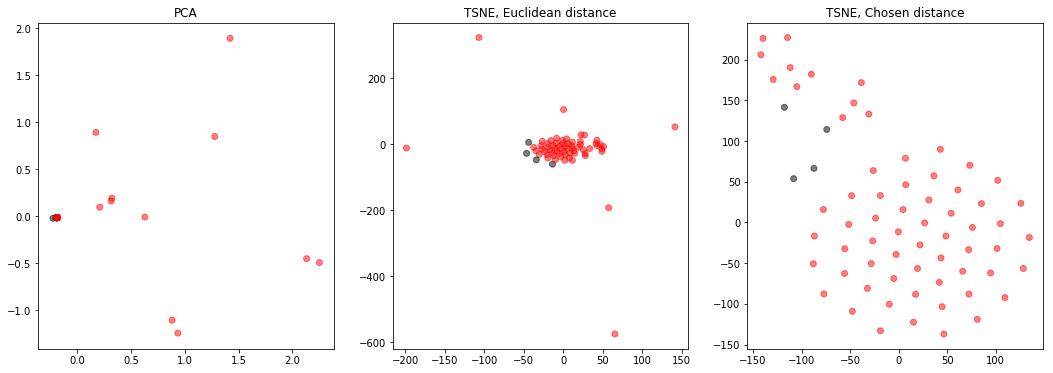

Clustering


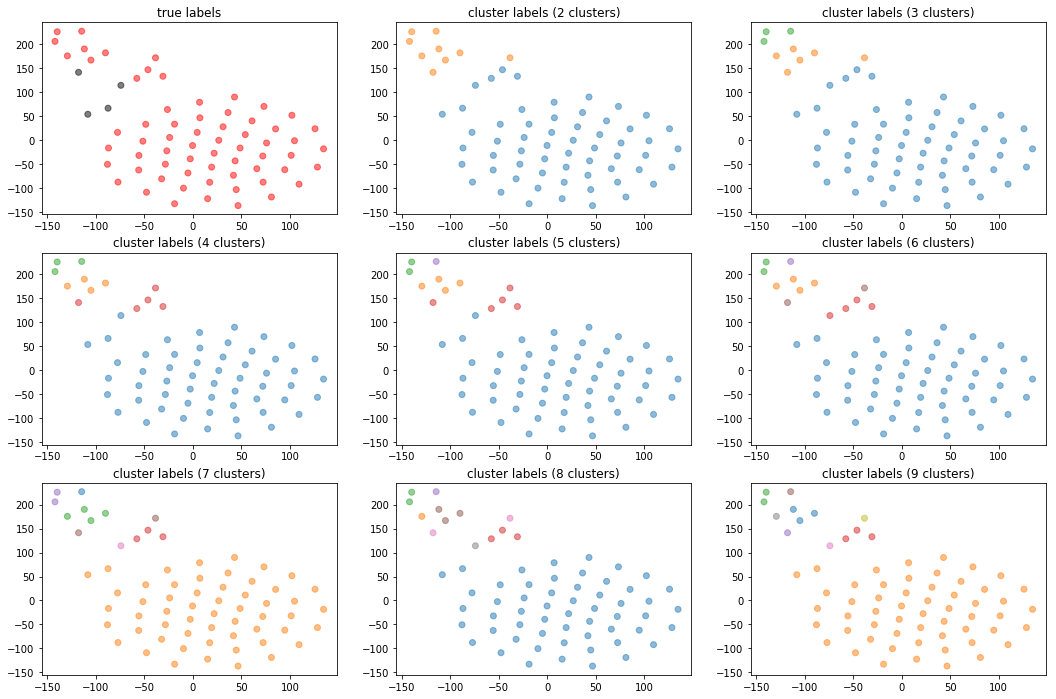

0 cluster


,s_MAIN_ID,s_class,s_nan_spectra,gev_1FGL_Name,gev_CLASS1,tev_fermi_names,tev_classes,marked
2,b'GCIRS 1W',B,False,b' ',b' ',b'',b'unid',0
5,b'[MCD2010] 13',O,False,b'1FGL J1746.4-2849c',b'pwn ',b'',b'unid',0
6,b'[MCD2010] 13',O,False,b'1FGL J1746.4-2849c',b'pwn ',b'',b'unid',0
7,b'[MT91] 213',B0Ve,False,b'1FGL J2032.2+4127 ',b'PSR ',b'',b'unid',1
9,b'LS I +61 303',B0Ve,False,b'1FGL J0240.5+6113 ',b'HMB ',b'',b'bin',1
10,b'[CHP2004] J095549.8+693934',B0Ve,True,b'1FGL J0956.5+6938 ',b'sbg ',"b'1FGL J0956.5+6938,2FGL J0955.9+6936,3FGL J09...",b'galaxy',0
11,b'[MTK2001b] 8',B0Ve,True,b'1FGL J0956.5+6938 ',b'sbg ',"b'1FGL J0956.5+6938,2FGL J0955.9+6936,3FGL J09...",b'galaxy',0
12,b'[CHP2004] J095637.5+694137',B0Ve,True,b'1FGL J0956.5+6938 ',b'sbg ',"b'1FGL J0956.5+6938,2FGL J0955.9+6936,3FGL J09...",b'galaxy',0
13,b'CXOU J095601.7+694308',B0Ve,True,b'1FGL J0956.5+6938 ',b'sbg ',"b'1FGL J0956.5+6938,2FGL J0955.9+6936,3FGL J09...",b'galaxy',0
14,b'CXOU J095548.9+694010',B0Ve,True,b'1FGL J0956.5+6938 ',b'sbg ',"b'1FGL J0956.5+6938,2FGL J0955.9+6936,3FGL J09...",b'galaxy',0


1 cluster


,s_MAIN_ID,s_class,s_nan_spectra,gev_1FGL_Name,gev_CLASS1,tev_fermi_names,tev_classes,marked
3,b'[MCD2010] 18',O,False,b'1FGL J1746.4-2849c',b'pwn ',b'',b'unid',0
8,b'Schulte 21',B0Ve,False,b'1FGL J2032.2+4127 ',b'PSR ',b'',b'unid',0
40,b'SN 2004am',B0Ve,False,b'1FGL J0956.5+6938 ',b'sbg ',"b'1FGL J0956.5+6938,2FGL J0955.9+6936,3FGL J09...",b'galaxy',0
54,b'CXOM82 J095538.3+694030',B0Ve,False,b'1FGL J0956.5+6938 ',b'sbg ',"b'1FGL J0956.5+6938,2FGL J0955.9+6936,3FGL J09...",b'galaxy',0
56,b'[KRL2007b] 332',B0Ve,False,b' ',b'PWN ',b'',b'unid',0
60,b'V* V479 Sct',B0Ve,False,b'1FGL J1826.2-1450 ',b'HMB ',b'',b'bin',1


2 cluster


,s_MAIN_ID,s_class,s_nan_spectra,gev_1FGL_Name,gev_CLASS1,tev_fermi_names,tev_classes,marked
0,b'SSTGC 519103',Be,False,b' ',b' ',b'',b'unid',0
1,b'LS IV -05 11',B,False,b' ',b'PWN ',b'',b'unid',0
4,b'GCIRS 8',O,False,b' ',b' ',b'',b'unid',0


centroids:


,gev_nuFnu10000_100000,gev_nuFnu1000_3000,gev_nuFnu100_300,gev_nuFnu3000_10000,gev_nuFnu300_1000,gev_nuFnu30_100,s_FLUX_U,s_FLUX_B,s_FLUX_V,s_FLUX_R,...,s_FLUX_u,s_FLUX_g,s_FLUX_r,s_FLUX_i,s_FLUX_z,tev_0.3TeV,tev_1TeV,tev_3TeV,tev_10TeV,tev_30TeV
0,0.001766,0.007966,0.000261,0.009813,0.005971,0.0,8.575174e-10,9.784230e-12,1.631650e-11,4.646779e-10,...,0.0,0.000000,0.000000,0.000000,0.0,0.004118,0.002245,0.002726,0.002839,0.003181
1,0.361603,0.348289,0.326643,0.384121,0.273748,0.0,1.666667e-01,9.789295e-03,1.125010e-02,1.666667e-01,...,0.0,0.166667,0.166667,0.166667,0.0,0.092540,0.132281,0.132848,0.190470,0.228753
2,0.113403,0.661694,0.056918,0.682433,0.653599,0.0,0.000000e+00,3.333333e-01,3.333333e-01,0.000000e+00,...,0.0,0.000000,0.000000,0.000000,0.0,0.735569,0.876171,0.859019,0.825985,0.381643


In [11]:
# earth mover's distance
metric_function = st.wasserstein_distance
spectra_distances = pairwise_distances(spectra[spectrum_columns], metric=metric_function)
# spectra_distances = get_distance_metric(metric_function).pairwise(spectra[spectrum_columns])
#pd.DataFrame(spectra_distances).to_csv(path_to_gamma_bins +"markeddata/gevtev_spectra_EM_distances.txt", index=False)
build_images(spectra_distances)
print_clusters_structure(spectra_distances, 3)

* ### euclidean distance

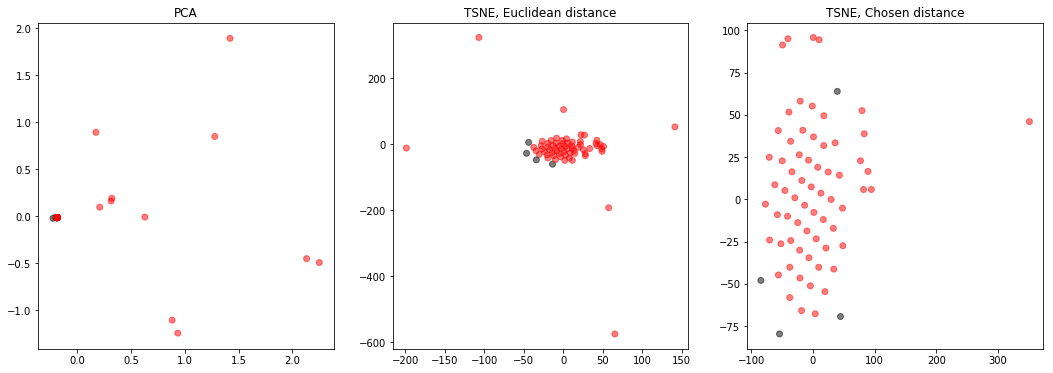

Clustering


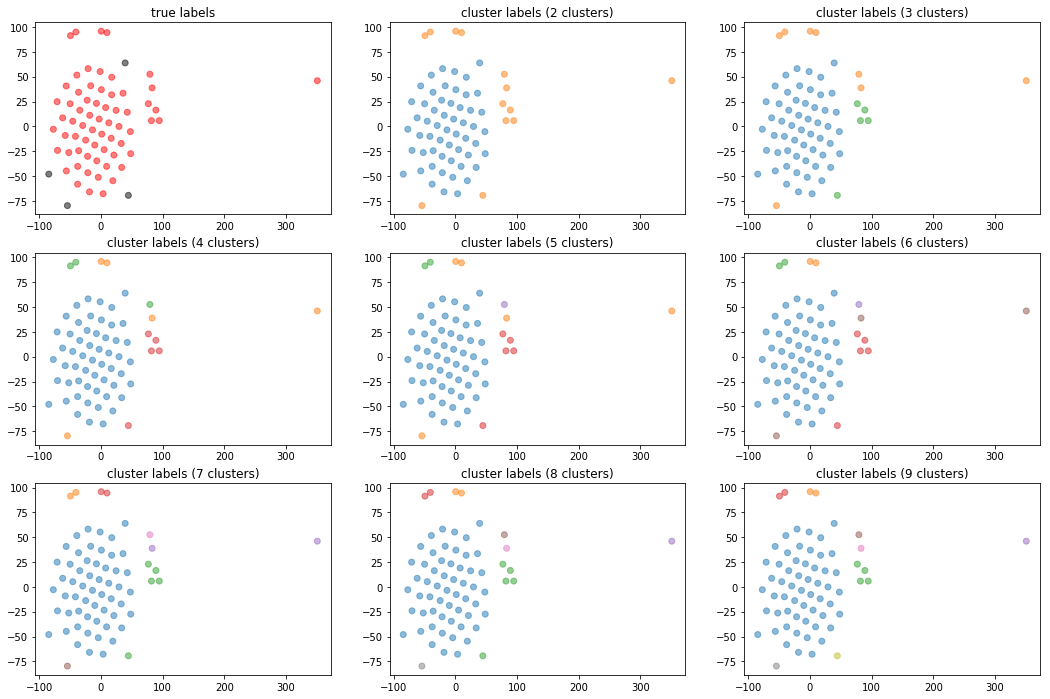

0 cluster


,s_MAIN_ID,s_class,s_nan_spectra,gev_1FGL_Name,gev_CLASS1,tev_fermi_names,tev_classes,marked
7,b'[MT91] 213',B0Ve,False,b'1FGL J2032.2+4127 ',b'PSR ',b'',b'unid',1
10,b'[CHP2004] J095549.8+693934',B0Ve,True,b'1FGL J0956.5+6938 ',b'sbg ',"b'1FGL J0956.5+6938,2FGL J0955.9+6936,3FGL J09...",b'galaxy',0
11,b'[MTK2001b] 8',B0Ve,True,b'1FGL J0956.5+6938 ',b'sbg ',"b'1FGL J0956.5+6938,2FGL J0955.9+6936,3FGL J09...",b'galaxy',0
12,b'[CHP2004] J095637.5+694137',B0Ve,True,b'1FGL J0956.5+6938 ',b'sbg ',"b'1FGL J0956.5+6938,2FGL J0955.9+6936,3FGL J09...",b'galaxy',0
13,b'CXOU J095601.7+694308',B0Ve,True,b'1FGL J0956.5+6938 ',b'sbg ',"b'1FGL J0956.5+6938,2FGL J0955.9+6936,3FGL J09...",b'galaxy',0
14,b'CXOU J095548.9+694010',B0Ve,True,b'1FGL J0956.5+6938 ',b'sbg ',"b'1FGL J0956.5+6938,2FGL J0955.9+6936,3FGL J09...",b'galaxy',0
15,b'CXOU J095527.1+693923',B0Ve,True,b'1FGL J0956.5+6938 ',b'sbg ',"b'1FGL J0956.5+6938,2FGL J0955.9+6936,3FGL J09...",b'galaxy',0
16,b'CXOU J095552.8+694020',B0Ve,True,b'1FGL J0956.5+6938 ',b'sbg ',"b'1FGL J0956.5+6938,2FGL J0955.9+6936,3FGL J09...",b'galaxy',0
17,b'CXOU J095552.4+694024',B0Ve,True,b'1FGL J0956.5+6938 ',b'sbg ',"b'1FGL J0956.5+6938,2FGL J0955.9+6936,3FGL J09...",b'galaxy',0
18,b'CXOU J095550.7+694039',B0Ve,True,b'1FGL J0956.5+6938 ',b'sbg ',"b'1FGL J0956.5+6938,2FGL J0955.9+6936,3FGL J09...",b'galaxy',0


1 cluster


,s_MAIN_ID,s_class,s_nan_spectra,gev_1FGL_Name,gev_CLASS1,tev_fermi_names,tev_classes,marked
0,b'SSTGC 519103',Be,False,b' ',b' ',b'',b'unid',0
1,b'LS IV -05 11',B,False,b' ',b'PWN ',b'',b'unid',0
4,b'GCIRS 8',O,False,b' ',b' ',b'',b'unid',0
8,b'Schulte 21',B0Ve,False,b'1FGL J2032.2+4127 ',b'PSR ',b'',b'unid',0
40,b'SN 2004am',B0Ve,False,b'1FGL J0956.5+6938 ',b'sbg ',"b'1FGL J0956.5+6938,2FGL J0955.9+6936,3FGL J09...",b'galaxy',0
54,b'CXOM82 J095538.3+694030',B0Ve,False,b'1FGL J0956.5+6938 ',b'sbg ',"b'1FGL J0956.5+6938,2FGL J0955.9+6936,3FGL J09...",b'galaxy',0
56,b'[KRL2007b] 332',B0Ve,False,b' ',b'PWN ',b'',b'unid',0
60,b'V* V479 Sct',B0Ve,False,b'1FGL J1826.2-1450 ',b'HMB ',b'',b'bin',1


2 cluster


,s_MAIN_ID,s_class,s_nan_spectra,gev_1FGL_Name,gev_CLASS1,tev_fermi_names,tev_classes,marked
2,b'GCIRS 1W',B,False,b' ',b' ',b'',b'unid',0
3,b'[MCD2010] 18',O,False,b'1FGL J1746.4-2849c',b'pwn ',b'',b'unid',0
5,b'[MCD2010] 13',O,False,b'1FGL J1746.4-2849c',b'pwn ',b'',b'unid',0
6,b'[MCD2010] 13',O,False,b'1FGL J1746.4-2849c',b'pwn ',b'',b'unid',0
9,b'LS I +61 303',B0Ve,False,b'1FGL J0240.5+6113 ',b'HMB ',b'',b'bin',1


centroids:


,gev_nuFnu10000_100000,gev_nuFnu1000_3000,gev_nuFnu100_300,gev_nuFnu3000_10000,gev_nuFnu300_1000,gev_nuFnu30_100,s_FLUX_U,s_FLUX_B,s_FLUX_V,s_FLUX_R,...,s_FLUX_u,s_FLUX_g,s_FLUX_r,s_FLUX_i,s_FLUX_z,tev_0.3TeV,tev_1TeV,tev_3TeV,tev_10TeV,tev_30TeV
0,1.754434e-12,3.513102e-12,3.332276e-12,5.103430e-12,3.691319e-12,0.0,1.281272e-11,3.439883e-13,1.038829e-12,0.000000e+00,...,0.0,0.000,0.000,0.000,0.0,2.964389e-13,2.253889e-13,2.609844e-13,8.366668e-13,2.825090e-12
1,3.015119e-01,4.622988e-01,2.656832e-01,4.821155e-01,4.193771e-01,0.0,1.250000e-01,1.323420e-01,1.334376e-01,1.250000e-01,...,0.0,0.125,0.125,0.125,0.0,3.128579e-01,4.255344e-01,4.117884e-01,4.347445e-01,2.681163e-01
2,4.038128e-02,1.692796e-01,4.112742e-03,2.148126e-01,1.201061e-01,0.0,9.977766e-09,1.116700e-10,1.811076e-10,5.483199e-09,...,0.0,0.000,0.000,0.000,0.0,1.004117e-01,3.007538e-02,4.813332e-02,6.206189e-02,1.120373e-01


In [12]:
# euclidean distance
from scipy.spatial.distance import euclidean
metric_function = "euclidean"
spectra_distances = pairwise_distances(spectra[spectrum_columns], metric=metric_function)
build_images(spectra_distances)
print_clusters_structure(spectra_distances, 3)

* ### cosine distance

$$ d(u, v) = 1 -  \frac{uv}{||u||_{2}||v||_{2}}$$

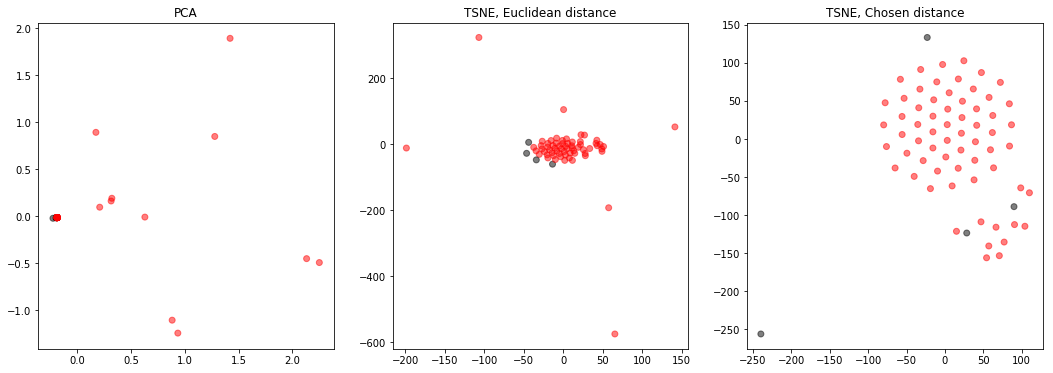

Clustering


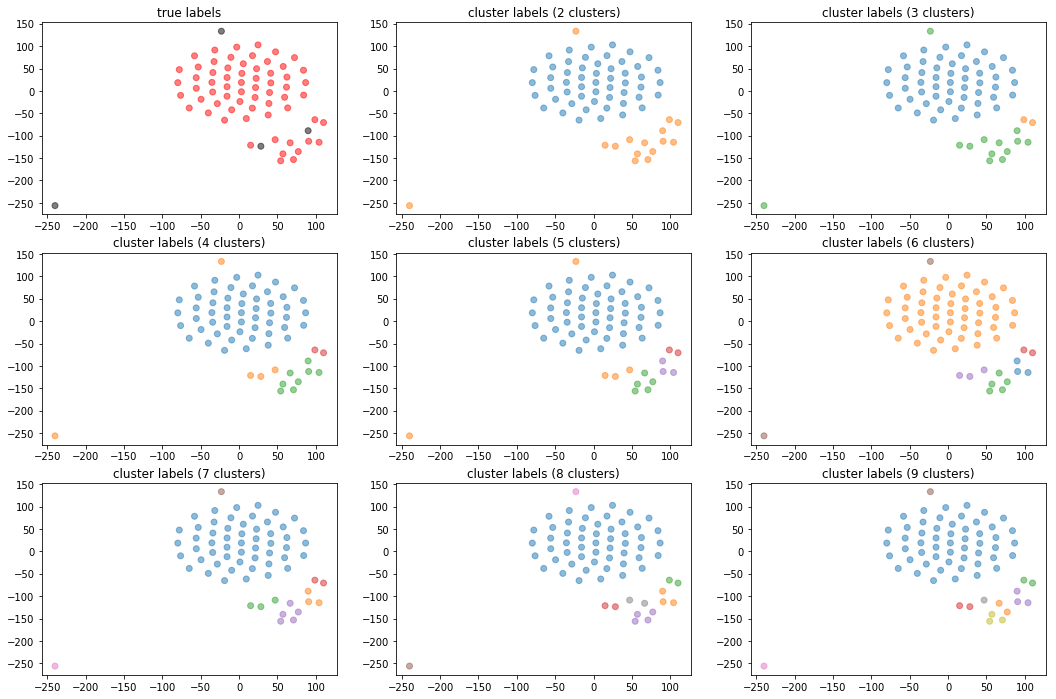

0 cluster


,s_MAIN_ID,s_class,s_nan_spectra,gev_1FGL_Name,gev_CLASS1,tev_fermi_names,tev_classes,marked
0,b'SSTGC 519103',Be,False,b' ',b' ',b'',b'unid',0
4,b'GCIRS 8',O,False,b' ',b' ',b'',b'unid',0
38,b'2FGL J1019.0-5856',B0Ve,True,b'1FGL J1018.6-5856 ',b'HMB ',b'1FGL J1018.6-5856',b'bin',1


1 cluster


,s_MAIN_ID,s_class,s_nan_spectra,gev_1FGL_Name,gev_CLASS1,tev_fermi_names,tev_classes,marked
10,b'[CHP2004] J095549.8+693934',B0Ve,True,b'1FGL J0956.5+6938 ',b'sbg ',"b'1FGL J0956.5+6938,2FGL J0955.9+6936,3FGL J09...",b'galaxy',0
11,b'[MTK2001b] 8',B0Ve,True,b'1FGL J0956.5+6938 ',b'sbg ',"b'1FGL J0956.5+6938,2FGL J0955.9+6936,3FGL J09...",b'galaxy',0
12,b'[CHP2004] J095637.5+694137',B0Ve,True,b'1FGL J0956.5+6938 ',b'sbg ',"b'1FGL J0956.5+6938,2FGL J0955.9+6936,3FGL J09...",b'galaxy',0
13,b'CXOU J095601.7+694308',B0Ve,True,b'1FGL J0956.5+6938 ',b'sbg ',"b'1FGL J0956.5+6938,2FGL J0955.9+6936,3FGL J09...",b'galaxy',0
14,b'CXOU J095548.9+694010',B0Ve,True,b'1FGL J0956.5+6938 ',b'sbg ',"b'1FGL J0956.5+6938,2FGL J0955.9+6936,3FGL J09...",b'galaxy',0
15,b'CXOU J095527.1+693923',B0Ve,True,b'1FGL J0956.5+6938 ',b'sbg ',"b'1FGL J0956.5+6938,2FGL J0955.9+6936,3FGL J09...",b'galaxy',0
16,b'CXOU J095552.8+694020',B0Ve,True,b'1FGL J0956.5+6938 ',b'sbg ',"b'1FGL J0956.5+6938,2FGL J0955.9+6936,3FGL J09...",b'galaxy',0
17,b'CXOU J095552.4+694024',B0Ve,True,b'1FGL J0956.5+6938 ',b'sbg ',"b'1FGL J0956.5+6938,2FGL J0955.9+6936,3FGL J09...",b'galaxy',0
18,b'CXOU J095550.7+694039',B0Ve,True,b'1FGL J0956.5+6938 ',b'sbg ',"b'1FGL J0956.5+6938,2FGL J0955.9+6936,3FGL J09...",b'galaxy',0
19,b'CXOU J095547.5+694120',B0Ve,True,b'1FGL J0956.5+6938 ',b'sbg ',"b'1FGL J0956.5+6938,2FGL J0955.9+6936,3FGL J09...",b'galaxy',0


2 cluster


,s_MAIN_ID,s_class,s_nan_spectra,gev_1FGL_Name,gev_CLASS1,tev_fermi_names,tev_classes,marked
2,b'GCIRS 1W',B,False,b' ',b' ',b'',b'unid',0
3,b'[MCD2010] 18',O,False,b'1FGL J1746.4-2849c',b'pwn ',b'',b'unid',0
5,b'[MCD2010] 13',O,False,b'1FGL J1746.4-2849c',b'pwn ',b'',b'unid',0
6,b'[MCD2010] 13',O,False,b'1FGL J1746.4-2849c',b'pwn ',b'',b'unid',0
56,b'[KRL2007b] 332',B0Ve,False,b' ',b'PWN ',b'',b'unid',0


3 cluster


,s_MAIN_ID,s_class,s_nan_spectra,gev_1FGL_Name,gev_CLASS1,tev_fermi_names,tev_classes,marked
40,b'SN 2004am',B0Ve,False,b'1FGL J0956.5+6938 ',b'sbg ',"b'1FGL J0956.5+6938,2FGL J0955.9+6936,3FGL J09...",b'galaxy',0
54,b'CXOM82 J095538.3+694030',B0Ve,False,b'1FGL J0956.5+6938 ',b'sbg ',"b'1FGL J0956.5+6938,2FGL J0955.9+6936,3FGL J09...",b'galaxy',0


4 cluster


,s_MAIN_ID,s_class,s_nan_spectra,gev_1FGL_Name,gev_CLASS1,tev_fermi_names,tev_classes,marked
1,b'LS IV -05 11',B,False,b' ',b'PWN ',b'',b'unid',0
7,b'[MT91] 213',B0Ve,False,b'1FGL J2032.2+4127 ',b'PSR ',b'',b'unid',1
8,b'Schulte 21',B0Ve,False,b'1FGL J2032.2+4127 ',b'PSR ',b'',b'unid',0


5 cluster


,s_MAIN_ID,s_class,s_nan_spectra,gev_1FGL_Name,gev_CLASS1,tev_fermi_names,tev_classes,marked
9,b'LS I +61 303',B0Ve,False,b'1FGL J0240.5+6113 ',b'HMB ',b'',b'bin',1
60,b'V* V479 Sct',B0Ve,False,b'1FGL J1826.2-1450 ',b'HMB ',b'',b'bin',1


centroids:


,gev_nuFnu10000_100000,gev_nuFnu1000_3000,gev_nuFnu100_300,gev_nuFnu3000_10000,gev_nuFnu300_1000,gev_nuFnu30_100,s_FLUX_U,s_FLUX_B,s_FLUX_V,s_FLUX_R,...,s_FLUX_u,s_FLUX_g,s_FLUX_r,s_FLUX_i,s_FLUX_z,tev_0.3TeV,tev_1TeV,tev_3TeV,tev_10TeV,tev_30TeV
0,7.529318e-02,6.487481e-01,5.580915e-02,6.487481e-01,6.487481e-01,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.0,0.0,0.0,0.0,0.0,6.487481e-01,6.487481e-01,6.487481e-01,5.328238e-01,8.848178e-02
1,1.475427e-12,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
2,6.638024e-02,1.781118e-01,4.868897e-03,2.377930e-01,1.234153e-01,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.0,0.0,0.0,0.0,0.0,1.596427e-01,1.852276e-01,1.915836e-01,2.620619e-01,3.120373e-01
3,9.677227e-01,8.168574e-01,9.677227e-01,8.175679e-01,6.761603e-01,0.0,1.433710e-09,1.397540e-10,3.143287e-05,0.000000e+00,...,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
4,4.025845e-02,2.475669e-02,6.270678e-03,5.354726e-02,1.330179e-02,0.0,3.333333e-01,3.529119e-01,3.558126e-01,3.333333e-01,...,0.0,0.0,0.0,0.0,0.0,8.682126e-02,2.274234e-01,2.102705e-01,2.931616e-01,2.931616e-01
5,3.072633e-11,1.822233e-10,4.959041e-10,1.776799e-10,3.020521e-10,0.0,2.938023e-08,3.461446e-10,5.895029e-10,1.564430e-08,...,0.0,0.5,0.5,0.5,0.0,1.037567e-09,9.495648e-10,1.013854e-09,1.252874e-09,7.305457e-10


In [13]:
# cosine distance
# from scipy.spatial.distance import cosine
metric_function = "cosine"
spectra_distances = pairwise_distances(spectra[spectrum_columns], metric=metric_function)
build_images(spectra_distances)
print_clusters_structure(spectra_distances, 6)

* ### energy distance

The energy distance between two distributions $u$ and $v$ , whose respective CDFs are $U$ and $V$, equals to: 
$$D(u, v) = (2\mathbb{E}|X-Y| - {E}|X-X'| - {E}|Y-Y'|)^{\frac{1}{2}}$$
where $X$ and $Y$ (resp. $X'$  and $Y'$ ) are independent random variables whose probability distribution is  (resp. ).

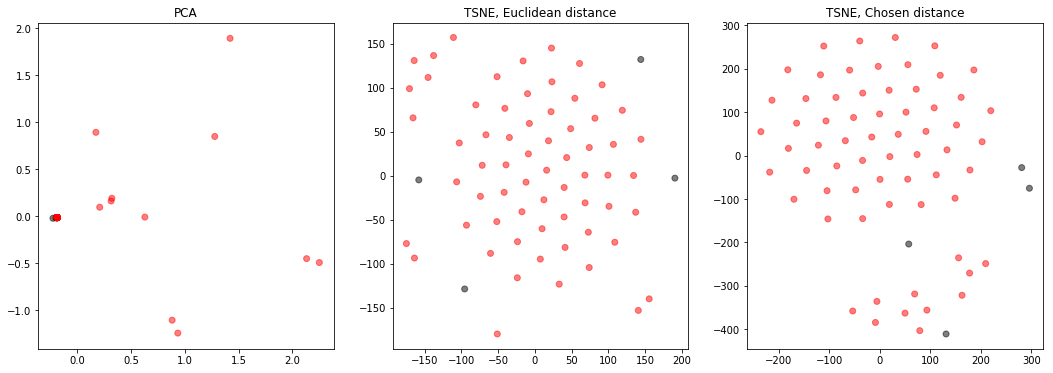

Clustering


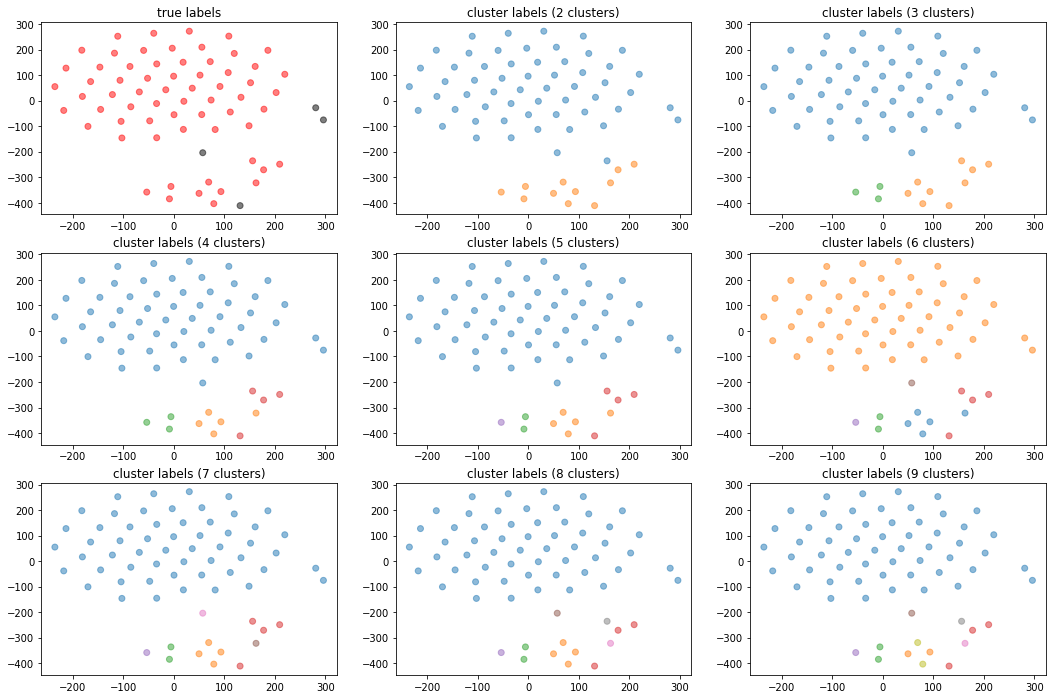

0 cluster


,s_MAIN_ID,s_class,s_nan_spectra,gev_1FGL_Name,gev_CLASS1,tev_fermi_names,tev_classes,marked
7,b'[MT91] 213',B0Ve,False,b'1FGL J2032.2+4127 ',b'PSR ',b'',b'unid',1
9,b'LS I +61 303',B0Ve,False,b'1FGL J0240.5+6113 ',b'HMB ',b'',b'bin',1
10,b'[CHP2004] J095549.8+693934',B0Ve,True,b'1FGL J0956.5+6938 ',b'sbg ',"b'1FGL J0956.5+6938,2FGL J0955.9+6936,3FGL J09...",b'galaxy',0
11,b'[MTK2001b] 8',B0Ve,True,b'1FGL J0956.5+6938 ',b'sbg ',"b'1FGL J0956.5+6938,2FGL J0955.9+6936,3FGL J09...",b'galaxy',0
12,b'[CHP2004] J095637.5+694137',B0Ve,True,b'1FGL J0956.5+6938 ',b'sbg ',"b'1FGL J0956.5+6938,2FGL J0955.9+6936,3FGL J09...",b'galaxy',0
13,b'CXOU J095601.7+694308',B0Ve,True,b'1FGL J0956.5+6938 ',b'sbg ',"b'1FGL J0956.5+6938,2FGL J0955.9+6936,3FGL J09...",b'galaxy',0
14,b'CXOU J095548.9+694010',B0Ve,True,b'1FGL J0956.5+6938 ',b'sbg ',"b'1FGL J0956.5+6938,2FGL J0955.9+6936,3FGL J09...",b'galaxy',0
15,b'CXOU J095527.1+693923',B0Ve,True,b'1FGL J0956.5+6938 ',b'sbg ',"b'1FGL J0956.5+6938,2FGL J0955.9+6936,3FGL J09...",b'galaxy',0
16,b'CXOU J095552.8+694020',B0Ve,True,b'1FGL J0956.5+6938 ',b'sbg ',"b'1FGL J0956.5+6938,2FGL J0955.9+6936,3FGL J09...",b'galaxy',0
17,b'CXOU J095552.4+694024',B0Ve,True,b'1FGL J0956.5+6938 ',b'sbg ',"b'1FGL J0956.5+6938,2FGL J0955.9+6936,3FGL J09...",b'galaxy',0


1 cluster


,s_MAIN_ID,s_class,s_nan_spectra,gev_1FGL_Name,gev_CLASS1,tev_fermi_names,tev_classes,marked
2,b'GCIRS 1W',B,False,b' ',b' ',b'',b'unid',0
3,b'[MCD2010] 18',O,False,b'1FGL J1746.4-2849c',b'pwn ',b'',b'unid',0
5,b'[MCD2010] 13',O,False,b'1FGL J1746.4-2849c',b'pwn ',b'',b'unid',0
6,b'[MCD2010] 13',O,False,b'1FGL J1746.4-2849c',b'pwn ',b'',b'unid',0
8,b'Schulte 21',B0Ve,False,b'1FGL J2032.2+4127 ',b'PSR ',b'',b'unid',0
40,b'SN 2004am',B0Ve,False,b'1FGL J0956.5+6938 ',b'sbg ',"b'1FGL J0956.5+6938,2FGL J0955.9+6936,3FGL J09...",b'galaxy',0
54,b'CXOM82 J095538.3+694030',B0Ve,False,b'1FGL J0956.5+6938 ',b'sbg ',"b'1FGL J0956.5+6938,2FGL J0955.9+6936,3FGL J09...",b'galaxy',0
56,b'[KRL2007b] 332',B0Ve,False,b' ',b'PWN ',b'',b'unid',0
60,b'V* V479 Sct',B0Ve,False,b'1FGL J1826.2-1450 ',b'HMB ',b'',b'bin',1


2 cluster


,s_MAIN_ID,s_class,s_nan_spectra,gev_1FGL_Name,gev_CLASS1,tev_fermi_names,tev_classes,marked
0,b'SSTGC 519103',Be,False,b' ',b' ',b'',b'unid',0
1,b'LS IV -05 11',B,False,b' ',b'PWN ',b'',b'unid',0
4,b'GCIRS 8',O,False,b' ',b' ',b'',b'unid',0


centroids:


,gev_nuFnu10000_100000,gev_nuFnu1000_3000,gev_nuFnu100_300,gev_nuFnu3000_10000,gev_nuFnu300_1000,gev_nuFnu30_100,s_FLUX_U,s_FLUX_B,s_FLUX_V,s_FLUX_R,...,s_FLUX_u,s_FLUX_g,s_FLUX_r,s_FLUX_i,s_FLUX_z,tev_0.3TeV,tev_1TeV,tev_3TeV,tev_10TeV,tev_30TeV
0,2.521884e-12,7.937704e-12,1.312390e-11,9.962681e-12,1.065340e-11,0.0,9.034559e-10,1.030838e-11,1.719060e-11,4.895714e-10,...,0.0,0.000000,0.000000,0.000000,0.0,3.808998e-12,1.143849e-12,1.512145e-12,1.853712e-12,5.210046e-12
1,2.526437e-01,2.844117e-01,2.194752e-01,3.204098e-01,2.216389e-01,0.0,1.111111e-01,6.526197e-03,7.500069e-03,1.111111e-01,...,0.0,0.111111,0.111111,0.111111,0.0,8.869038e-02,1.029042e-01,1.064353e-01,1.455899e-01,1.733540e-01
2,1.134027e-01,6.616944e-01,5.691753e-02,6.824330e-01,6.535989e-01,0.0,0.000000e+00,3.333333e-01,3.333333e-01,0.000000e+00,...,0.0,0.000000,0.000000,0.000000,0.0,7.355694e-01,8.761715e-01,8.590186e-01,8.259854e-01,3.816434e-01


In [14]:
# energy distance
metric_function = st.energy_distance
spectra_distances = pairwise_distances(spectra[spectrum_columns], metric=metric_function)
build_images(spectra_distances, TSNE_learning_rate=400, TSNE_n_iter=1000, TSNE_learning_rate2=900)
print_clusters_structure(spectra_distances, 3)

In [15]:
#func = lambda x, y : mahalanobis(x, y, invcovmx)

- ### canberra
$$d(u, v) = \sum_{i} \frac{|u_i - v_i|}{|u_i| + |v_i|}$$

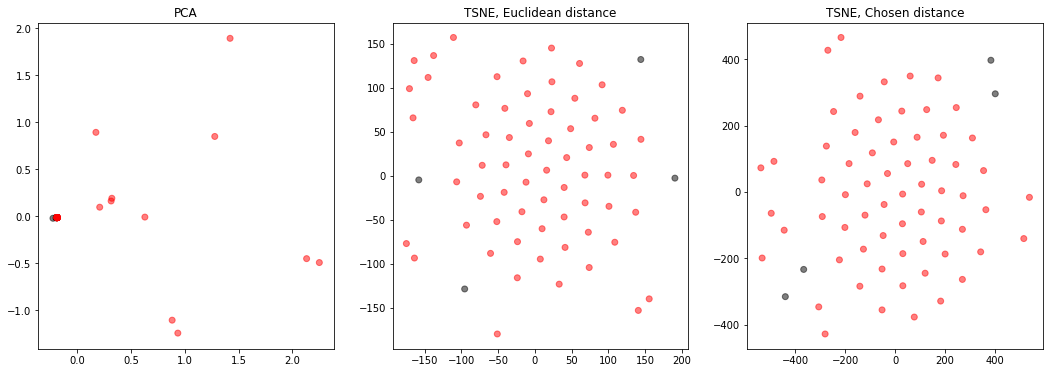

Clustering


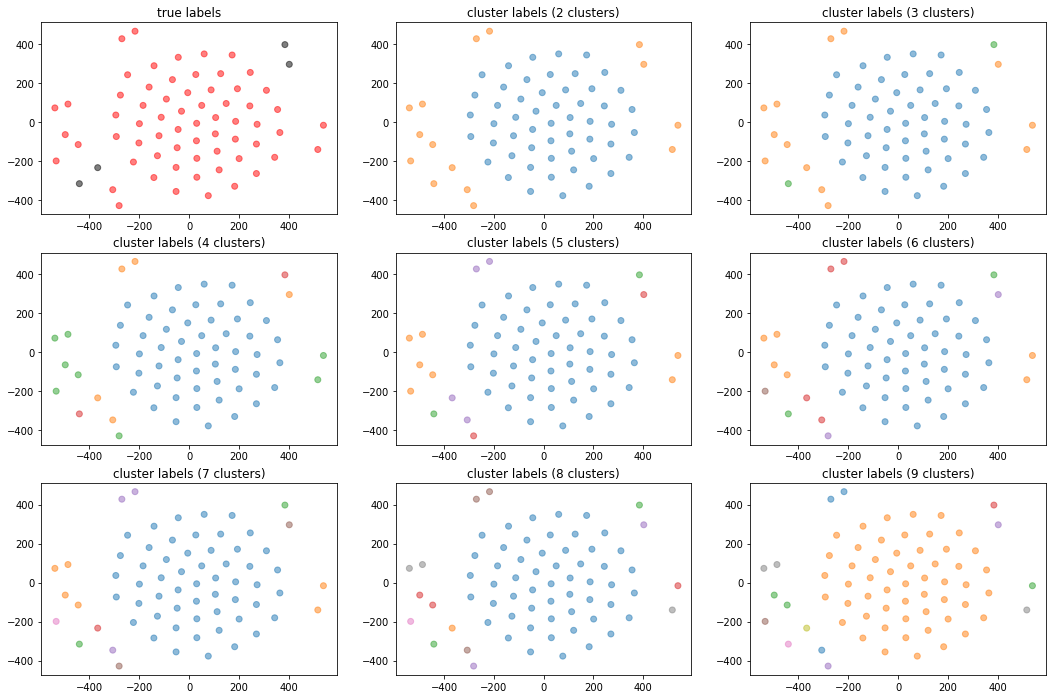

0 cluster


,s_MAIN_ID,s_class,s_nan_spectra,gev_1FGL_Name,gev_CLASS1,tev_fermi_names,tev_classes,marked
10,b'[CHP2004] J095549.8+693934',B0Ve,True,b'1FGL J0956.5+6938 ',b'sbg ',"b'1FGL J0956.5+6938,2FGL J0955.9+6936,3FGL J09...",b'galaxy',0
11,b'[MTK2001b] 8',B0Ve,True,b'1FGL J0956.5+6938 ',b'sbg ',"b'1FGL J0956.5+6938,2FGL J0955.9+6936,3FGL J09...",b'galaxy',0
12,b'[CHP2004] J095637.5+694137',B0Ve,True,b'1FGL J0956.5+6938 ',b'sbg ',"b'1FGL J0956.5+6938,2FGL J0955.9+6936,3FGL J09...",b'galaxy',0
13,b'CXOU J095601.7+694308',B0Ve,True,b'1FGL J0956.5+6938 ',b'sbg ',"b'1FGL J0956.5+6938,2FGL J0955.9+6936,3FGL J09...",b'galaxy',0
14,b'CXOU J095548.9+694010',B0Ve,True,b'1FGL J0956.5+6938 ',b'sbg ',"b'1FGL J0956.5+6938,2FGL J0955.9+6936,3FGL J09...",b'galaxy',0
15,b'CXOU J095527.1+693923',B0Ve,True,b'1FGL J0956.5+6938 ',b'sbg ',"b'1FGL J0956.5+6938,2FGL J0955.9+6936,3FGL J09...",b'galaxy',0
16,b'CXOU J095552.8+694020',B0Ve,True,b'1FGL J0956.5+6938 ',b'sbg ',"b'1FGL J0956.5+6938,2FGL J0955.9+6936,3FGL J09...",b'galaxy',0
17,b'CXOU J095552.4+694024',B0Ve,True,b'1FGL J0956.5+6938 ',b'sbg ',"b'1FGL J0956.5+6938,2FGL J0955.9+6936,3FGL J09...",b'galaxy',0
18,b'CXOU J095550.7+694039',B0Ve,True,b'1FGL J0956.5+6938 ',b'sbg ',"b'1FGL J0956.5+6938,2FGL J0955.9+6936,3FGL J09...",b'galaxy',0
19,b'CXOU J095547.5+694120',B0Ve,True,b'1FGL J0956.5+6938 ',b'sbg ',"b'1FGL J0956.5+6938,2FGL J0955.9+6936,3FGL J09...",b'galaxy',0


1 cluster


,s_MAIN_ID,s_class,s_nan_spectra,gev_1FGL_Name,gev_CLASS1,tev_fermi_names,tev_classes,marked
0,b'SSTGC 519103',Be,False,b' ',b' ',b'',b'unid',0
1,b'LS IV -05 11',B,False,b' ',b'PWN ',b'',b'unid',0
2,b'GCIRS 1W',B,False,b' ',b' ',b'',b'unid',0
3,b'[MCD2010] 18',O,False,b'1FGL J1746.4-2849c',b'pwn ',b'',b'unid',0
4,b'GCIRS 8',O,False,b' ',b' ',b'',b'unid',0
5,b'[MCD2010] 13',O,False,b'1FGL J1746.4-2849c',b'pwn ',b'',b'unid',0
6,b'[MCD2010] 13',O,False,b'1FGL J1746.4-2849c',b'pwn ',b'',b'unid',0
7,b'[MT91] 213',B0Ve,False,b'1FGL J2032.2+4127 ',b'PSR ',b'',b'unid',1
8,b'Schulte 21',B0Ve,False,b'1FGL J2032.2+4127 ',b'PSR ',b'',b'unid',0
38,b'2FGL J1019.0-5856',B0Ve,True,b'1FGL J1018.6-5856 ',b'HMB ',b'1FGL J1018.6-5856',b'bin',1


2 cluster


,s_MAIN_ID,s_class,s_nan_spectra,gev_1FGL_Name,gev_CLASS1,tev_fermi_names,tev_classes,marked
9,b'LS I +61 303',B0Ve,False,b'1FGL J0240.5+6113 ',b'HMB ',b'',b'bin',1
60,b'V* V479 Sct',B0Ve,False,b'1FGL J1826.2-1450 ',b'HMB ',b'',b'bin',1


centroids:


,gev_nuFnu10000_100000,gev_nuFnu1000_3000,gev_nuFnu100_300,gev_nuFnu3000_10000,gev_nuFnu300_1000,gev_nuFnu30_100,s_FLUX_U,s_FLUX_B,s_FLUX_V,s_FLUX_R,...,s_FLUX_u,s_FLUX_g,s_FLUX_r,s_FLUX_i,s_FLUX_z,tev_0.3TeV,tev_1TeV,tev_3TeV,tev_10TeV,tev_30TeV
0,1.475427e-12,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
1,2.010770e-01,3.495991e-01,1.650792e-01,3.793067e-01,3.042728e-01,0.0,7.692308e-02,8.144121e-02,8.211543e-02,7.692308e-02,...,0.0,0.0,0.0,0.0,0.0,2.311478e-01,2.734348e-01,2.719211e-01,2.914050e-01,2.080859e-01
2,3.072633e-11,1.822233e-10,4.959041e-10,1.776799e-10,3.020521e-10,0.0,2.938023e-08,3.461446e-10,5.895029e-10,1.564430e-08,...,0.0,0.5,0.5,0.5,0.0,1.037567e-09,9.495648e-10,1.013854e-09,1.252874e-09,7.305457e-10


In [16]:
metric_function = "canberra"
spectra_distances = pairwise_distances(spectra[spectrum_columns], metric=metric_function)
build_images(spectra_distances, TSNE_learning_rate=400, TSNE_n_iter=1000, TSNE_learning_rate2=900)
print_clusters_structure(spectra_distances, 3)

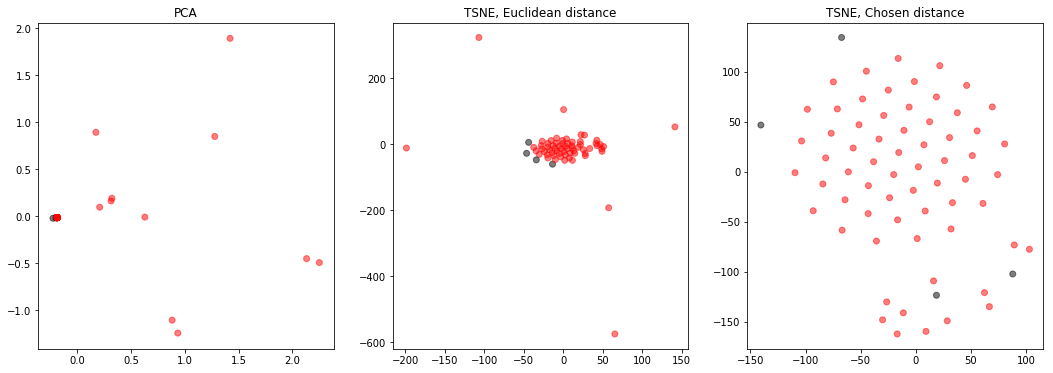

Clustering


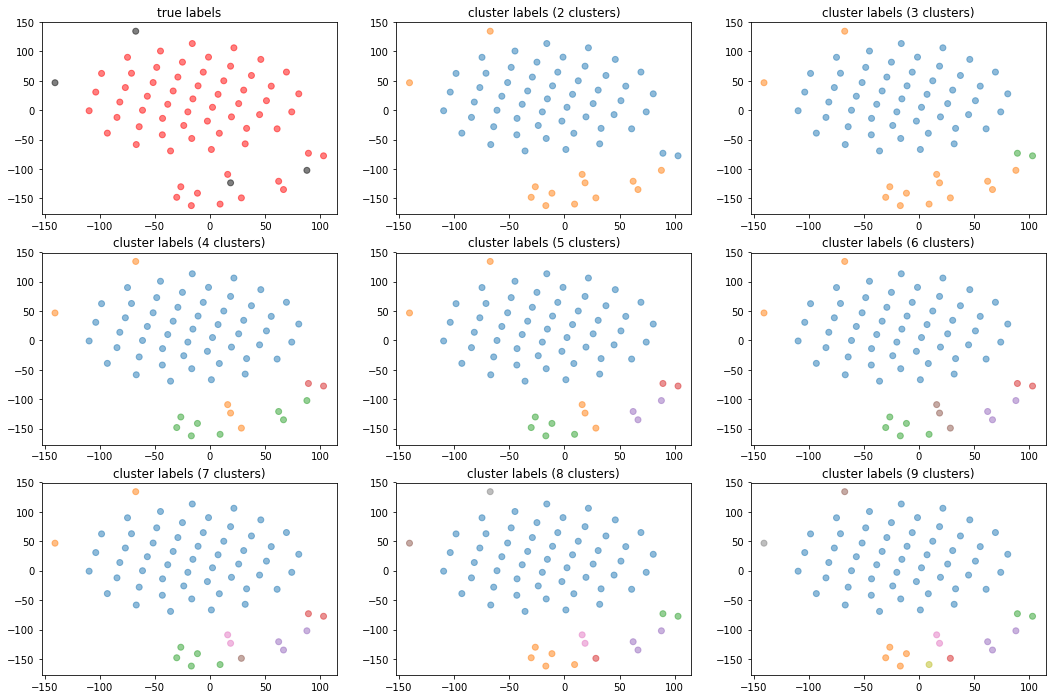

0 cluster


,s_MAIN_ID,s_class,s_nan_spectra,gev_1FGL_Name,gev_CLASS1,tev_fermi_names,tev_classes,marked
10,b'[CHP2004] J095549.8+693934',B0Ve,True,b'1FGL J0956.5+6938 ',b'sbg ',"b'1FGL J0956.5+6938,2FGL J0955.9+6936,3FGL J09...",b'galaxy',0
11,b'[MTK2001b] 8',B0Ve,True,b'1FGL J0956.5+6938 ',b'sbg ',"b'1FGL J0956.5+6938,2FGL J0955.9+6936,3FGL J09...",b'galaxy',0
12,b'[CHP2004] J095637.5+694137',B0Ve,True,b'1FGL J0956.5+6938 ',b'sbg ',"b'1FGL J0956.5+6938,2FGL J0955.9+6936,3FGL J09...",b'galaxy',0
13,b'CXOU J095601.7+694308',B0Ve,True,b'1FGL J0956.5+6938 ',b'sbg ',"b'1FGL J0956.5+6938,2FGL J0955.9+6936,3FGL J09...",b'galaxy',0
14,b'CXOU J095548.9+694010',B0Ve,True,b'1FGL J0956.5+6938 ',b'sbg ',"b'1FGL J0956.5+6938,2FGL J0955.9+6936,3FGL J09...",b'galaxy',0
15,b'CXOU J095527.1+693923',B0Ve,True,b'1FGL J0956.5+6938 ',b'sbg ',"b'1FGL J0956.5+6938,2FGL J0955.9+6936,3FGL J09...",b'galaxy',0
16,b'CXOU J095552.8+694020',B0Ve,True,b'1FGL J0956.5+6938 ',b'sbg ',"b'1FGL J0956.5+6938,2FGL J0955.9+6936,3FGL J09...",b'galaxy',0
17,b'CXOU J095552.4+694024',B0Ve,True,b'1FGL J0956.5+6938 ',b'sbg ',"b'1FGL J0956.5+6938,2FGL J0955.9+6936,3FGL J09...",b'galaxy',0
18,b'CXOU J095550.7+694039',B0Ve,True,b'1FGL J0956.5+6938 ',b'sbg ',"b'1FGL J0956.5+6938,2FGL J0955.9+6936,3FGL J09...",b'galaxy',0
19,b'CXOU J095547.5+694120',B0Ve,True,b'1FGL J0956.5+6938 ',b'sbg ',"b'1FGL J0956.5+6938,2FGL J0955.9+6936,3FGL J09...",b'galaxy',0


1 cluster


,s_MAIN_ID,s_class,s_nan_spectra,gev_1FGL_Name,gev_CLASS1,tev_fermi_names,tev_classes,marked
1,b'LS IV -05 11',B,False,b' ',b'PWN ',b'',b'unid',0
7,b'[MT91] 213',B0Ve,False,b'1FGL J2032.2+4127 ',b'PSR ',b'',b'unid',1
8,b'Schulte 21',B0Ve,False,b'1FGL J2032.2+4127 ',b'PSR ',b'',b'unid',0
9,b'LS I +61 303',B0Ve,False,b'1FGL J0240.5+6113 ',b'HMB ',b'',b'bin',1
60,b'V* V479 Sct',B0Ve,False,b'1FGL J1826.2-1450 ',b'HMB ',b'',b'bin',1


2 cluster


,s_MAIN_ID,s_class,s_nan_spectra,gev_1FGL_Name,gev_CLASS1,tev_fermi_names,tev_classes,marked
2,b'GCIRS 1W',B,False,b' ',b' ',b'',b'unid',0
3,b'[MCD2010] 18',O,False,b'1FGL J1746.4-2849c',b'pwn ',b'',b'unid',0
5,b'[MCD2010] 13',O,False,b'1FGL J1746.4-2849c',b'pwn ',b'',b'unid',0
6,b'[MCD2010] 13',O,False,b'1FGL J1746.4-2849c',b'pwn ',b'',b'unid',0
56,b'[KRL2007b] 332',B0Ve,False,b' ',b'PWN ',b'',b'unid',0


3 cluster


,s_MAIN_ID,s_class,s_nan_spectra,gev_1FGL_Name,gev_CLASS1,tev_fermi_names,tev_classes,marked
40,b'SN 2004am',B0Ve,False,b'1FGL J0956.5+6938 ',b'sbg ',"b'1FGL J0956.5+6938,2FGL J0955.9+6936,3FGL J09...",b'galaxy',0
54,b'CXOM82 J095538.3+694030',B0Ve,False,b'1FGL J0956.5+6938 ',b'sbg ',"b'1FGL J0956.5+6938,2FGL J0955.9+6936,3FGL J09...",b'galaxy',0


4 cluster


,s_MAIN_ID,s_class,s_nan_spectra,gev_1FGL_Name,gev_CLASS1,tev_fermi_names,tev_classes,marked
0,b'SSTGC 519103',Be,False,b' ',b' ',b'',b'unid',0
4,b'GCIRS 8',O,False,b' ',b' ',b'',b'unid',0
38,b'2FGL J1019.0-5856',B0Ve,True,b'1FGL J1018.6-5856 ',b'HMB ',b'1FGL J1018.6-5856',b'bin',1


centroids:


,gev_nuFnu10000_100000,gev_nuFnu1000_3000,gev_nuFnu100_300,gev_nuFnu3000_10000,gev_nuFnu300_1000,gev_nuFnu30_100,s_FLUX_U,s_FLUX_B,s_FLUX_V,s_FLUX_R,...,s_FLUX_u,s_FLUX_g,s_FLUX_r,s_FLUX_i,s_FLUX_z,tev_0.3TeV,tev_1TeV,tev_3TeV,tev_10TeV,tev_30TeV
0,1.475427e-12,0.000000,0.000000,0.000000,0.000000,0.0,0.000000e+00,0.000000e+00,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
1,2.415507e-02,0.014854,0.003762,0.032128,0.007981,0.0,2.000000e-01,2.117472e-01,0.213488,0.2,...,0.0,0.2,0.2,0.2,0.0,0.052093,0.136454,0.126162,0.175897,0.175897
2,6.638024e-02,0.178112,0.004869,0.237793,0.123415,0.0,0.000000e+00,0.000000e+00,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.159643,0.185228,0.191584,0.262062,0.312037
3,9.677227e-01,0.816857,0.967723,0.817568,0.676160,0.0,1.433710e-09,1.397540e-10,0.000031,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
4,7.529318e-02,0.648748,0.055809,0.648748,0.648748,0.0,0.000000e+00,0.000000e+00,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.648748,0.648748,0.648748,0.532824,0.088482


In [17]:
metric_function = "correlation"
spectra_distances = pairwise_distances(spectra[spectrum_columns], metric=metric_function)
build_images(spectra_distances)
print_clusters_structure(spectra_distances, 5)

- ### cityblock
$$ d(u, v) = \sum_{i} |u_i - v_i|$$

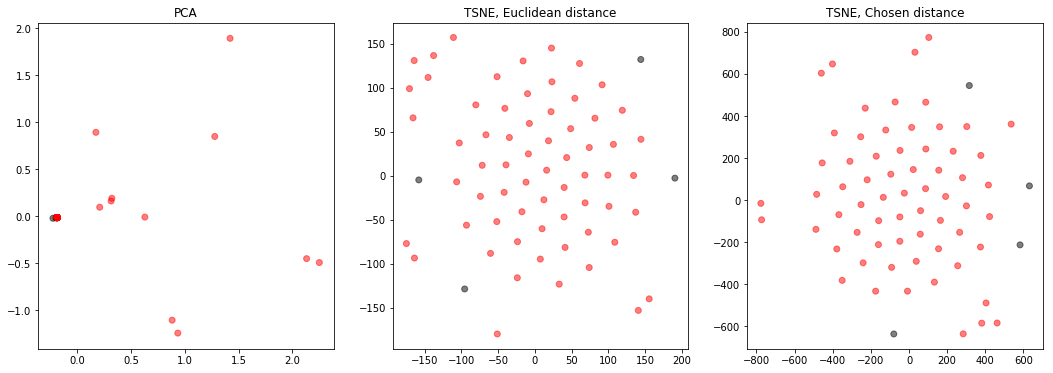

Clustering


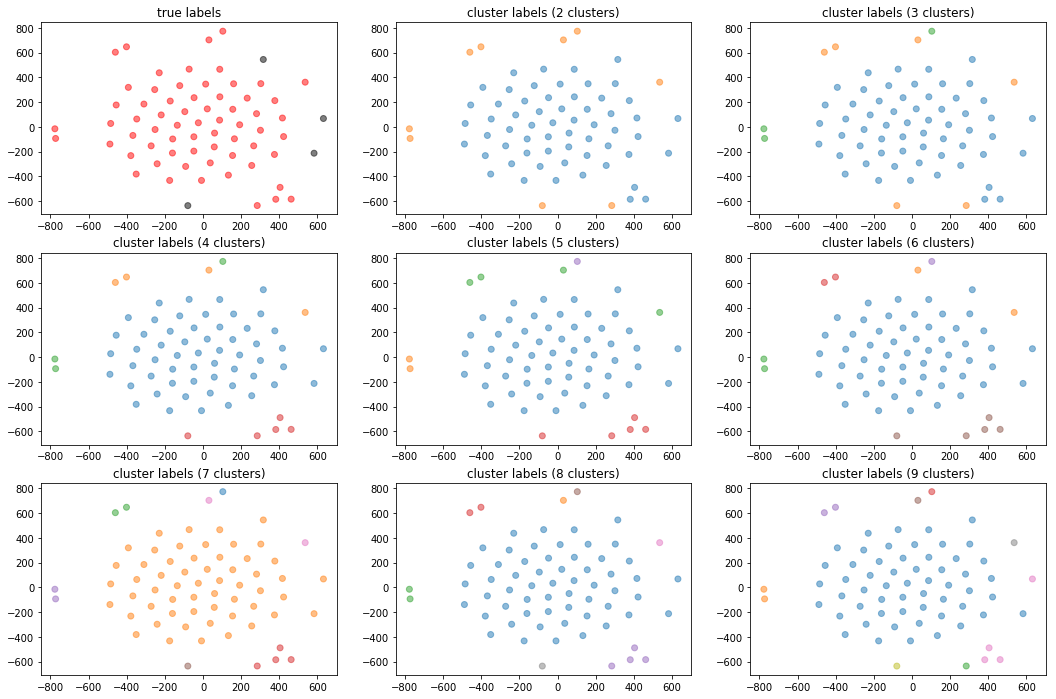

0 cluster


,s_MAIN_ID,s_class,s_nan_spectra,gev_1FGL_Name,gev_CLASS1,tev_fermi_names,tev_classes,marked
2,b'GCIRS 1W',B,False,b' ',b' ',b'',b'unid',0
5,b'[MCD2010] 13',O,False,b'1FGL J1746.4-2849c',b'pwn ',b'',b'unid',0
6,b'[MCD2010] 13',O,False,b'1FGL J1746.4-2849c',b'pwn ',b'',b'unid',0
7,b'[MT91] 213',B0Ve,False,b'1FGL J2032.2+4127 ',b'PSR ',b'',b'unid',1
9,b'LS I +61 303',B0Ve,False,b'1FGL J0240.5+6113 ',b'HMB ',b'',b'bin',1
10,b'[CHP2004] J095549.8+693934',B0Ve,True,b'1FGL J0956.5+6938 ',b'sbg ',"b'1FGL J0956.5+6938,2FGL J0955.9+6936,3FGL J09...",b'galaxy',0
11,b'[MTK2001b] 8',B0Ve,True,b'1FGL J0956.5+6938 ',b'sbg ',"b'1FGL J0956.5+6938,2FGL J0955.9+6936,3FGL J09...",b'galaxy',0
12,b'[CHP2004] J095637.5+694137',B0Ve,True,b'1FGL J0956.5+6938 ',b'sbg ',"b'1FGL J0956.5+6938,2FGL J0955.9+6936,3FGL J09...",b'galaxy',0
13,b'CXOU J095601.7+694308',B0Ve,True,b'1FGL J0956.5+6938 ',b'sbg ',"b'1FGL J0956.5+6938,2FGL J0955.9+6936,3FGL J09...",b'galaxy',0
14,b'CXOU J095548.9+694010',B0Ve,True,b'1FGL J0956.5+6938 ',b'sbg ',"b'1FGL J0956.5+6938,2FGL J0955.9+6936,3FGL J09...",b'galaxy',0


1 cluster


,s_MAIN_ID,s_class,s_nan_spectra,gev_1FGL_Name,gev_CLASS1,tev_fermi_names,tev_classes,marked
3,b'[MCD2010] 18',O,False,b'1FGL J1746.4-2849c',b'pwn ',b'',b'unid',0
8,b'Schulte 21',B0Ve,False,b'1FGL J2032.2+4127 ',b'PSR ',b'',b'unid',0
40,b'SN 2004am',B0Ve,False,b'1FGL J0956.5+6938 ',b'sbg ',"b'1FGL J0956.5+6938,2FGL J0955.9+6936,3FGL J09...",b'galaxy',0
54,b'CXOM82 J095538.3+694030',B0Ve,False,b'1FGL J0956.5+6938 ',b'sbg ',"b'1FGL J0956.5+6938,2FGL J0955.9+6936,3FGL J09...",b'galaxy',0
56,b'[KRL2007b] 332',B0Ve,False,b' ',b'PWN ',b'',b'unid',0
60,b'V* V479 Sct',B0Ve,False,b'1FGL J1826.2-1450 ',b'HMB ',b'',b'bin',1


2 cluster


,s_MAIN_ID,s_class,s_nan_spectra,gev_1FGL_Name,gev_CLASS1,tev_fermi_names,tev_classes,marked
0,b'SSTGC 519103',Be,False,b' ',b' ',b'',b'unid',0
1,b'LS IV -05 11',B,False,b' ',b'PWN ',b'',b'unid',0
4,b'GCIRS 8',O,False,b' ',b' ',b'',b'unid',0


centroids:


,gev_nuFnu10000_100000,gev_nuFnu1000_3000,gev_nuFnu100_300,gev_nuFnu3000_10000,gev_nuFnu300_1000,gev_nuFnu30_100,s_FLUX_U,s_FLUX_B,s_FLUX_V,s_FLUX_R,...,s_FLUX_u,s_FLUX_g,s_FLUX_r,s_FLUX_i,s_FLUX_z,tev_0.3TeV,tev_1TeV,tev_3TeV,tev_10TeV,tev_30TeV
0,0.001766,0.007966,0.000261,0.009813,0.005971,0.0,8.575174e-10,9.784230e-12,1.631650e-11,4.646779e-10,...,0.0,0.000000,0.000000,0.000000,0.0,0.004118,0.002245,0.002726,0.002839,0.003181
1,0.361603,0.348289,0.326643,0.384121,0.273748,0.0,1.666667e-01,9.789295e-03,1.125010e-02,1.666667e-01,...,0.0,0.166667,0.166667,0.166667,0.0,0.092540,0.132281,0.132848,0.190470,0.228753
2,0.113403,0.661694,0.056918,0.682433,0.653599,0.0,0.000000e+00,3.333333e-01,3.333333e-01,0.000000e+00,...,0.0,0.000000,0.000000,0.000000,0.0,0.735569,0.876171,0.859019,0.825985,0.381643


In [18]:
metric_function = "cityblock"
spectra_distances = pairwise_distances(spectra[spectrum_columns], metric=metric_function)
build_images(spectra_distances, TSNE_learning_rate=400, TSNE_n_iter=1000, TSNE_learning_rate2=900)
print_clusters_structure(spectra_distances, 3)

- ### braycurtis $$d(u, v) = \frac{\sum_{i} |u_i - v_i|}{\sum_{i}|u_i + v_i|}$$

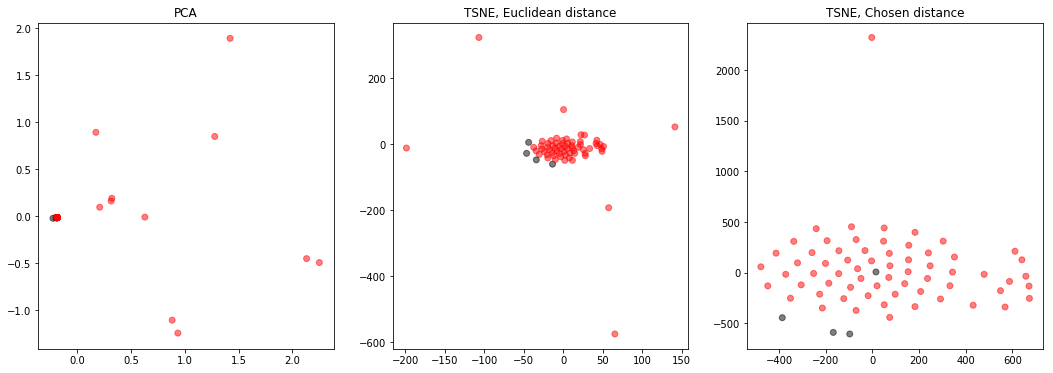

Clustering


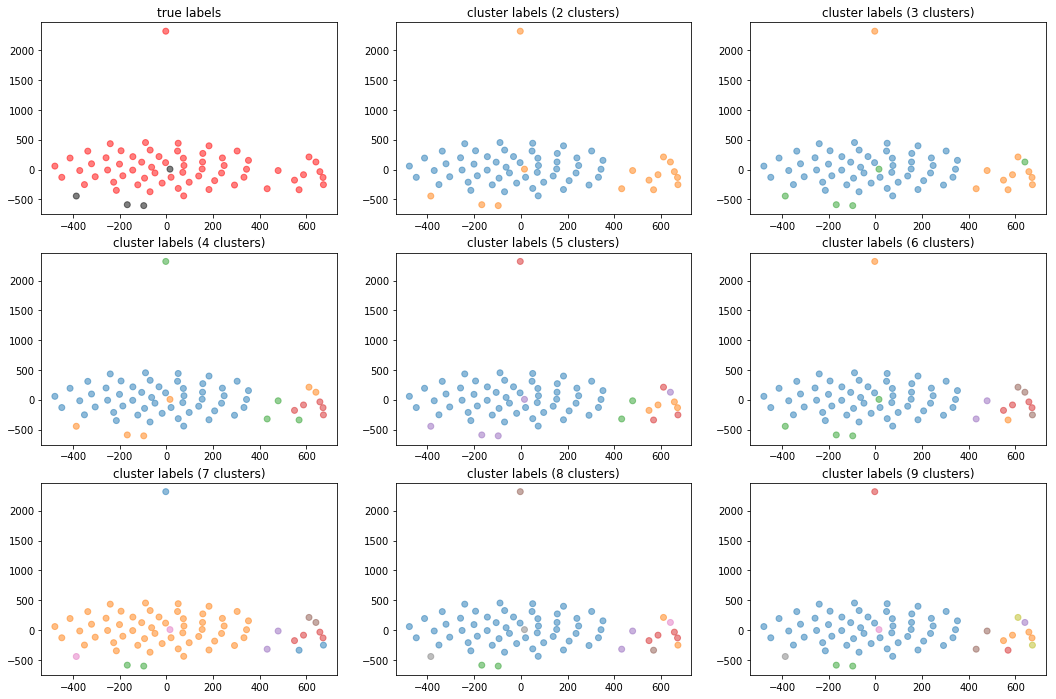

0 cluster


,s_MAIN_ID,s_class,s_nan_spectra,gev_1FGL_Name,gev_CLASS1,tev_fermi_names,tev_classes,marked
10,b'[CHP2004] J095549.8+693934',B0Ve,True,b'1FGL J0956.5+6938 ',b'sbg ',"b'1FGL J0956.5+6938,2FGL J0955.9+6936,3FGL J09...",b'galaxy',0
11,b'[MTK2001b] 8',B0Ve,True,b'1FGL J0956.5+6938 ',b'sbg ',"b'1FGL J0956.5+6938,2FGL J0955.9+6936,3FGL J09...",b'galaxy',0
12,b'[CHP2004] J095637.5+694137',B0Ve,True,b'1FGL J0956.5+6938 ',b'sbg ',"b'1FGL J0956.5+6938,2FGL J0955.9+6936,3FGL J09...",b'galaxy',0
13,b'CXOU J095601.7+694308',B0Ve,True,b'1FGL J0956.5+6938 ',b'sbg ',"b'1FGL J0956.5+6938,2FGL J0955.9+6936,3FGL J09...",b'galaxy',0
14,b'CXOU J095548.9+694010',B0Ve,True,b'1FGL J0956.5+6938 ',b'sbg ',"b'1FGL J0956.5+6938,2FGL J0955.9+6936,3FGL J09...",b'galaxy',0
15,b'CXOU J095527.1+693923',B0Ve,True,b'1FGL J0956.5+6938 ',b'sbg ',"b'1FGL J0956.5+6938,2FGL J0955.9+6936,3FGL J09...",b'galaxy',0
16,b'CXOU J095552.8+694020',B0Ve,True,b'1FGL J0956.5+6938 ',b'sbg ',"b'1FGL J0956.5+6938,2FGL J0955.9+6936,3FGL J09...",b'galaxy',0
17,b'CXOU J095552.4+694024',B0Ve,True,b'1FGL J0956.5+6938 ',b'sbg ',"b'1FGL J0956.5+6938,2FGL J0955.9+6936,3FGL J09...",b'galaxy',0
18,b'CXOU J095550.7+694039',B0Ve,True,b'1FGL J0956.5+6938 ',b'sbg ',"b'1FGL J0956.5+6938,2FGL J0955.9+6936,3FGL J09...",b'galaxy',0
19,b'CXOU J095547.5+694120',B0Ve,True,b'1FGL J0956.5+6938 ',b'sbg ',"b'1FGL J0956.5+6938,2FGL J0955.9+6936,3FGL J09...",b'galaxy',0


1 cluster


,s_MAIN_ID,s_class,s_nan_spectra,gev_1FGL_Name,gev_CLASS1,tev_fermi_names,tev_classes,marked
0,b'SSTGC 519103',Be,False,b' ',b' ',b'',b'unid',0
1,b'LS IV -05 11',B,False,b' ',b'PWN ',b'',b'unid',0
2,b'GCIRS 1W',B,False,b' ',b' ',b'',b'unid',0
3,b'[MCD2010] 18',O,False,b'1FGL J1746.4-2849c',b'pwn ',b'',b'unid',0
4,b'GCIRS 8',O,False,b' ',b' ',b'',b'unid',0
5,b'[MCD2010] 13',O,False,b'1FGL J1746.4-2849c',b'pwn ',b'',b'unid',0
6,b'[MCD2010] 13',O,False,b'1FGL J1746.4-2849c',b'pwn ',b'',b'unid',0
40,b'SN 2004am',B0Ve,False,b'1FGL J0956.5+6938 ',b'sbg ',"b'1FGL J0956.5+6938,2FGL J0955.9+6936,3FGL J09...",b'galaxy',0
54,b'CXOM82 J095538.3+694030',B0Ve,False,b'1FGL J0956.5+6938 ',b'sbg ',"b'1FGL J0956.5+6938,2FGL J0955.9+6936,3FGL J09...",b'galaxy',0
56,b'[KRL2007b] 332',B0Ve,False,b' ',b'PWN ',b'',b'unid',0


2 cluster


,s_MAIN_ID,s_class,s_nan_spectra,gev_1FGL_Name,gev_CLASS1,tev_fermi_names,tev_classes,marked
7,b'[MT91] 213',B0Ve,False,b'1FGL J2032.2+4127 ',b'PSR ',b'',b'unid',1
8,b'Schulte 21',B0Ve,False,b'1FGL J2032.2+4127 ',b'PSR ',b'',b'unid',0
9,b'LS I +61 303',B0Ve,False,b'1FGL J0240.5+6113 ',b'HMB ',b'',b'bin',1
38,b'2FGL J1019.0-5856',B0Ve,True,b'1FGL J1018.6-5856 ',b'HMB ',b'1FGL J1018.6-5856',b'bin',1
60,b'V* V479 Sct',B0Ve,False,b'1FGL J1826.2-1450 ',b'HMB ',b'',b'bin',1


centroids:


,gev_nuFnu10000_100000,gev_nuFnu1000_3000,gev_nuFnu100_300,gev_nuFnu3000_10000,gev_nuFnu300_1000,gev_nuFnu30_100,s_FLUX_U,s_FLUX_B,s_FLUX_V,s_FLUX_R,...,s_FLUX_u,s_FLUX_g,s_FLUX_r,s_FLUX_i,s_FLUX_z,tev_0.3TeV,tev_1TeV,tev_3TeV,tev_10TeV,tev_30TeV
0,1.475427e-12,0.000000,0.000000,0.000000,0.000000,0.0,0.000000e+00,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
1,2.607555e-01,0.450936,0.213054,0.487140,0.393019,0.0,2.867420e-10,0.100000,0.100006,0.0,...,0.0,0.0,0.0,0.0,0.0,3.004922e-01,3.554652e-01,3.534974e-01,3.788266e-01,2.705116e-01
2,1.289383e-03,0.007086,0.003097,0.011917,0.005071,0.0,2.000000e-01,0.011747,0.013488,0.2,...,0.0,0.2,0.2,0.2,0.0,4.182878e-10,3.823052e-10,4.084126e-10,5.103528e-10,3.232943e-10


In [19]:
metric_function = "braycurtis"
spectra_distances = pairwise_distances(spectra[spectrum_columns], metric=metric_function)
build_images(spectra_distances)
print_clusters_structure(spectra_distances, 3)

- ### corellation 
$$d(u, v) = 1 -  \frac{(u - \overline{u}) \cdot (v - \overline{v})}{||(u - \overline{u})||_{2} \cdot  ||(v - \overline{v})||_{2}}$$

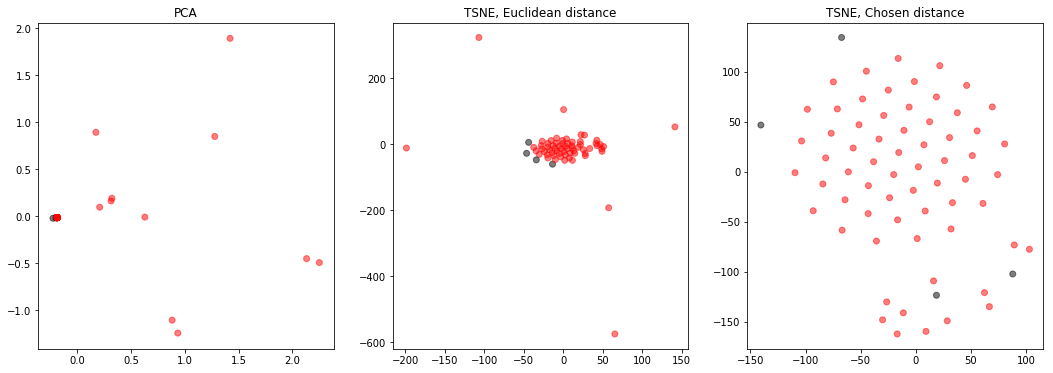

Clustering


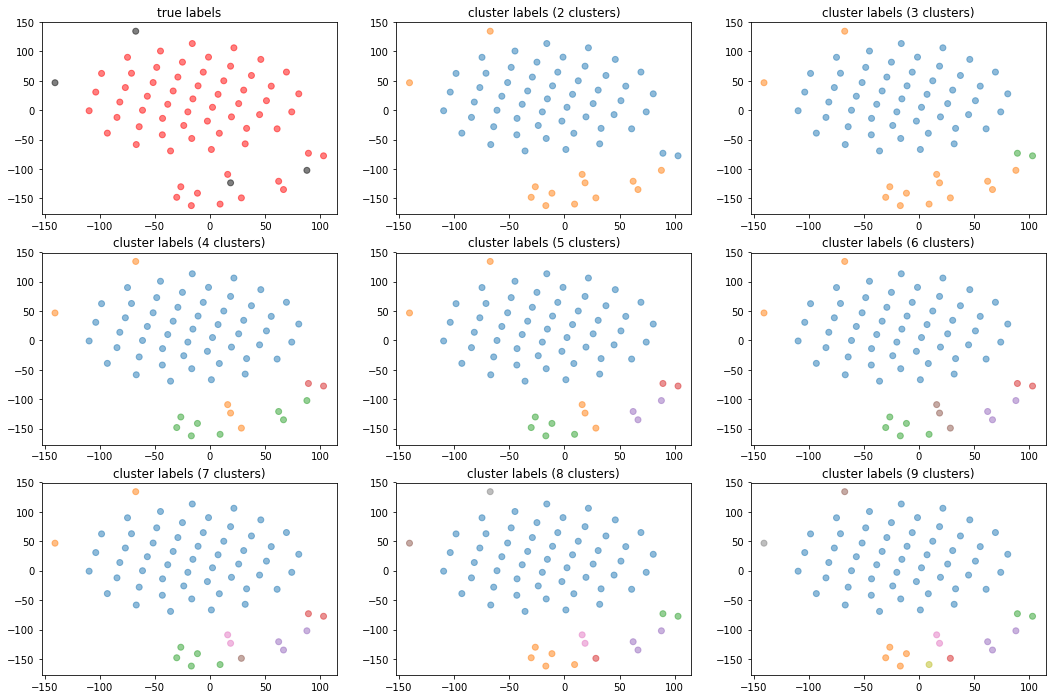

0 cluster


,s_MAIN_ID,s_class,s_nan_spectra,gev_1FGL_Name,gev_CLASS1,tev_fermi_names,tev_classes,marked
10,b'[CHP2004] J095549.8+693934',B0Ve,True,b'1FGL J0956.5+6938 ',b'sbg ',"b'1FGL J0956.5+6938,2FGL J0955.9+6936,3FGL J09...",b'galaxy',0
11,b'[MTK2001b] 8',B0Ve,True,b'1FGL J0956.5+6938 ',b'sbg ',"b'1FGL J0956.5+6938,2FGL J0955.9+6936,3FGL J09...",b'galaxy',0
12,b'[CHP2004] J095637.5+694137',B0Ve,True,b'1FGL J0956.5+6938 ',b'sbg ',"b'1FGL J0956.5+6938,2FGL J0955.9+6936,3FGL J09...",b'galaxy',0
13,b'CXOU J095601.7+694308',B0Ve,True,b'1FGL J0956.5+6938 ',b'sbg ',"b'1FGL J0956.5+6938,2FGL J0955.9+6936,3FGL J09...",b'galaxy',0
14,b'CXOU J095548.9+694010',B0Ve,True,b'1FGL J0956.5+6938 ',b'sbg ',"b'1FGL J0956.5+6938,2FGL J0955.9+6936,3FGL J09...",b'galaxy',0
15,b'CXOU J095527.1+693923',B0Ve,True,b'1FGL J0956.5+6938 ',b'sbg ',"b'1FGL J0956.5+6938,2FGL J0955.9+6936,3FGL J09...",b'galaxy',0
16,b'CXOU J095552.8+694020',B0Ve,True,b'1FGL J0956.5+6938 ',b'sbg ',"b'1FGL J0956.5+6938,2FGL J0955.9+6936,3FGL J09...",b'galaxy',0
17,b'CXOU J095552.4+694024',B0Ve,True,b'1FGL J0956.5+6938 ',b'sbg ',"b'1FGL J0956.5+6938,2FGL J0955.9+6936,3FGL J09...",b'galaxy',0
18,b'CXOU J095550.7+694039',B0Ve,True,b'1FGL J0956.5+6938 ',b'sbg ',"b'1FGL J0956.5+6938,2FGL J0955.9+6936,3FGL J09...",b'galaxy',0
19,b'CXOU J095547.5+694120',B0Ve,True,b'1FGL J0956.5+6938 ',b'sbg ',"b'1FGL J0956.5+6938,2FGL J0955.9+6936,3FGL J09...",b'galaxy',0


1 cluster


,s_MAIN_ID,s_class,s_nan_spectra,gev_1FGL_Name,gev_CLASS1,tev_fermi_names,tev_classes,marked
0,b'SSTGC 519103',Be,False,b' ',b' ',b'',b'unid',0
1,b'LS IV -05 11',B,False,b' ',b'PWN ',b'',b'unid',0
2,b'GCIRS 1W',B,False,b' ',b' ',b'',b'unid',0
3,b'[MCD2010] 18',O,False,b'1FGL J1746.4-2849c',b'pwn ',b'',b'unid',0
4,b'GCIRS 8',O,False,b' ',b' ',b'',b'unid',0
5,b'[MCD2010] 13',O,False,b'1FGL J1746.4-2849c',b'pwn ',b'',b'unid',0
6,b'[MCD2010] 13',O,False,b'1FGL J1746.4-2849c',b'pwn ',b'',b'unid',0
7,b'[MT91] 213',B0Ve,False,b'1FGL J2032.2+4127 ',b'PSR ',b'',b'unid',1
8,b'Schulte 21',B0Ve,False,b'1FGL J2032.2+4127 ',b'PSR ',b'',b'unid',0
9,b'LS I +61 303',B0Ve,False,b'1FGL J0240.5+6113 ',b'HMB ',b'',b'bin',1


2 cluster


,s_MAIN_ID,s_class,s_nan_spectra,gev_1FGL_Name,gev_CLASS1,tev_fermi_names,tev_classes,marked
40,b'SN 2004am',B0Ve,False,b'1FGL J0956.5+6938 ',b'sbg ',"b'1FGL J0956.5+6938,2FGL J0955.9+6936,3FGL J09...",b'galaxy',0
54,b'CXOM82 J095538.3+694030',B0Ve,False,b'1FGL J0956.5+6938 ',b'sbg ',"b'1FGL J0956.5+6938,2FGL J0955.9+6936,3FGL J09...",b'galaxy',0


centroids:


,gev_nuFnu10000_100000,gev_nuFnu1000_3000,gev_nuFnu100_300,gev_nuFnu3000_10000,gev_nuFnu300_1000,gev_nuFnu30_100,s_FLUX_U,s_FLUX_B,s_FLUX_V,s_FLUX_R,...,s_FLUX_u,s_FLUX_g,s_FLUX_r,s_FLUX_i,s_FLUX_z,tev_0.3TeV,tev_1TeV,tev_3TeV,tev_10TeV,tev_30TeV
0,1.475427e-12,0.000000,0.000000,0.000000,0.000000,0.0,0.000000e+00,0.000000e+00,0.000000,0.000000,...,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
1,5.219662e-02,0.223929,0.016199,0.253527,0.200248,0.0,7.692308e-02,8.144121e-02,0.082111,0.076923,...,0.0,0.076923,0.076923,0.076923,0.0,0.231148,0.273435,0.271921,0.291405,0.208086
2,9.677227e-01,0.816857,0.967723,0.817568,0.676160,0.0,1.433710e-09,1.397540e-10,0.000031,0.000000,...,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000


In [20]:
metric_function = "correlation"
spectra_distances = pairwise_distances(spectra[spectrum_columns], metric=metric_function)
build_images(spectra_distances)
print_clusters_structure(spectra_distances, 3)

# Spectra comparation

In [21]:
import matplotlib.gridspec as gridspec
def show_marked_spectra(spectrum_columns, spectra=spectra, simbad_number=6):
    plt.clf()
    plt.figure(figsize=(16,6))
    gs = gridspec.GridSpec(4, 2, wspace=0.1, hspace=0.02)
    marked_spectra = spectra[spectra['marked'] == 1]
    non_normalized_marked_spectra = non_normalized_spectra[non_normalized_spectra['marked'] == 1]
    axes = []
    for i in range(0,4):

        table = marked_spectra[spectrum_columns].iloc[i]
        values = table.values
        spectrum_order = np.hstack((values[simbad_number:],values[0:simbad_number]))

        non_normalized_table = non_normalized_marked_spectra[spectrum_columns].iloc[i]
        non_normalized_values = non_normalized_table.values
        non_normalized_spectrum_order = np.hstack((non_normalized_values[simbad_number:],non_normalized_values[0:simbad_number]))
        spectra_points_number = len(spectrum_columns)
        ax = plt.subplot(gs[i, 0])
        plt.xticks(())
        if i == 0:
            plt.setp([ax], title='Normalized columns')
        if i == 3:
            ax.set_xlabel('optics - gev - tev')
            plt.xticks(range(spectra_points_number), (np.hstack((spectrum_columns[simbad_number:],spectrum_columns[0:simbad_number]))))
            plt.setp(ax.xaxis.get_majorticklabels(), rotation=45)
        ax.plot(range(len(values)), spectrum_order)
        ax.set_ylabel(marked_spectra['s_MAIN_ID'].values[i])

        ax = plt.subplot(gs[i, 1])        
        plt.xticks(())
        if i== 0:
            plt.setp([ax], title='Non normalized columns')
        if i == 3:
            ax.set_xlabel('optics - gev - tev')
            plt.xticks(range(spectra_points_number), (np.hstack((spectrum_columns[simbad_number:],spectrum_columns[0:simbad_number]))))
            plt.setp(ax.xaxis.get_majorticklabels(), rotation=45)
        ax.plot(range(len(values)), non_normalized_spectrum_order)    

    plt.show()

In [22]:
def show_marked_spectra2(spectrum_columns, spectra=spectra, simbad_number=6):
    plt.clf()
    fig, ax = plt.subplots(figsize=(16,6))
    marked_spectra = spectra[spectra['marked'] == 1]
    for i in range(0,4):

        table = marked_spectra[spectrum_columns].iloc[i]
        values = table.values
        spectrum_order = np.hstack((values[simbad_number:],values[0:simbad_number]))

        spectra_points_number = len(spectrum_columns)
        plt.xticks(())
        #if i == 0:
        #    plt.setp([plt], title='Normalized columns')
        if i == 3:
            #plt.set_xlabel('optics - gev - tev')
            plt.xticks(range(spectra_points_number), (np.hstack((spectrum_columns[simbad_number:],spectrum_columns[0:simbad_number]))),rotation=45)
        ax.plot(range(len(values)), spectrum_order, label=marked_spectra['s_MAIN_ID'].values[i])
        legend = ax.legend(loc = 'upper right')   

    plt.show()

All catalogs for normalized columns and normalized spectra:

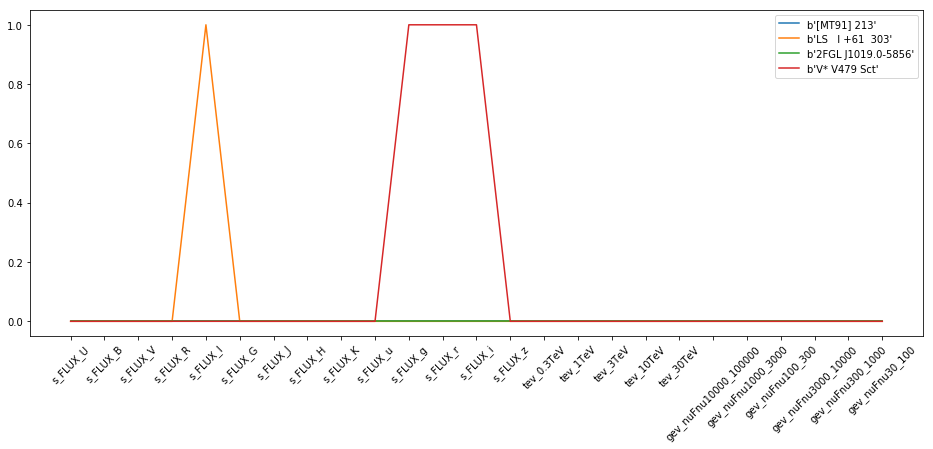

In [23]:
show_marked_spectra2(spectrum_columns)

All catalogs for non normalized columns and normalized spectra:

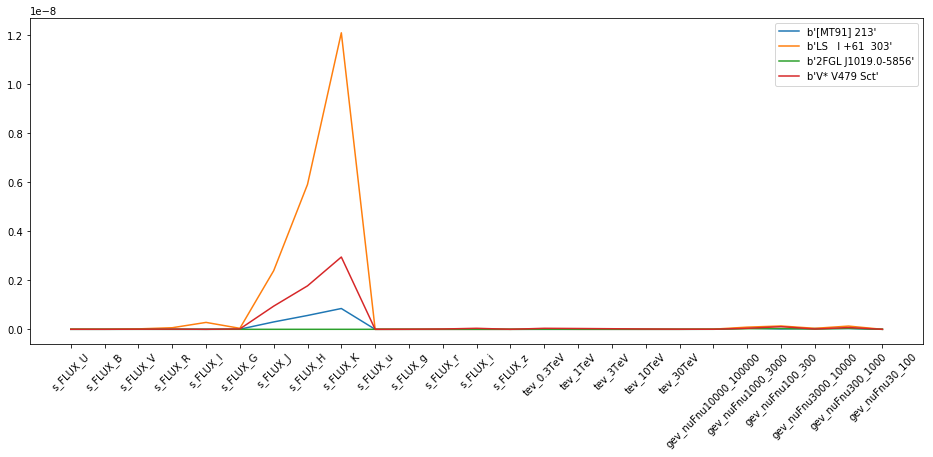

In [24]:
show_marked_spectra2(spectrum_columns, non_normalized_spectra)

In [25]:
path_to_catalog = "markeddata/non_normalized_spectra.txt"
spectra_without_line_normalization = pd.read_csv(path_to_gamma_bins +path_to_catalog)
spectra_without_line_normalization.head()


,gev_nuFnu10000_100000,gev_nuFnu1000_3000,gev_nuFnu100_300,gev_nuFnu3000_10000,gev_nuFnu300_1000,gev_nuFnu30_100,s_FLUX_U,s_FLUX_B,s_FLUX_V,s_FLUX_R,...,tev_3TeV,tev_10TeV,tev_30TeV,s_MAIN_ID,s_class,gev_1FGL_Name,gev_CLASS1,tev_fermi_names,tev_classes,marked
0,2.938044e-12,7.446349e-11,4.520060e-12,3.103834e-11,7.171538e-11,0.0,0.0,0.000000e+00,0.000000e+00,0.0,...,2.633748e-12,8.977128e-13,8.824638e-14,b'SSTGC 519103',Be,b' ',b' ',b'',b'unid',0
1,2.098420e-11,2.096862e-11,1.266728e-12,2.274123e-11,7.566604e-12,0.0,0.0,6.918312e-12,3.090294e-11,0.0,...,1.204573e-11,6.969757e-12,4.125786e-12,b'LS IV -05 11',B,b' ',b'PWN ',b'',b'unid',0
2,2.938044e-12,7.446349e-11,4.520060e-12,3.103834e-11,7.171538e-11,0.0,0.0,0.000000e+00,0.000000e+00,0.0,...,2.633748e-12,8.977128e-13,8.824638e-14,b'GCIRS 1W',B,b' ',b' ',b'',b'unid',0
3,4.706814e-12,5.332763e-11,5.145968e-13,2.923599e-11,3.387356e-11,0.0,0.0,0.000000e+00,0.000000e+00,0.0,...,4.000469e-13,2.969888e-13,4.585589e-13,b'[MCD2010] 18',O,b'1FGL J1746.4-2849c',b'pwn ',b'',b'unid',0
4,2.938044e-12,7.446349e-11,4.520060e-12,3.103834e-11,7.171538e-11,0.0,0.0,0.000000e+00,0.000000e+00,0.0,...,2.633748e-12,8.977128e-13,8.824638e-14,b'GCIRS 8',O,b' ',b' ',b'',b'unid',0


All catalogs for non normalized columns and non normalized spectra:

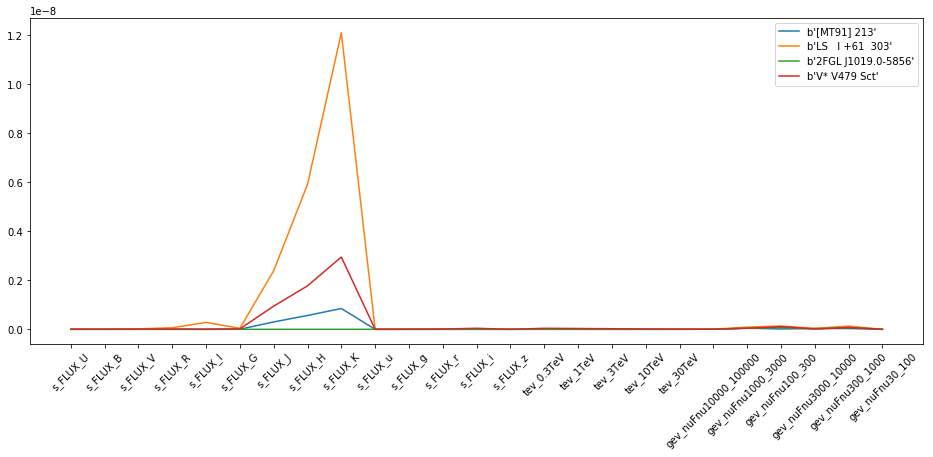

In [26]:
show_marked_spectra2(spectrum_columns, spectra_without_line_normalization)

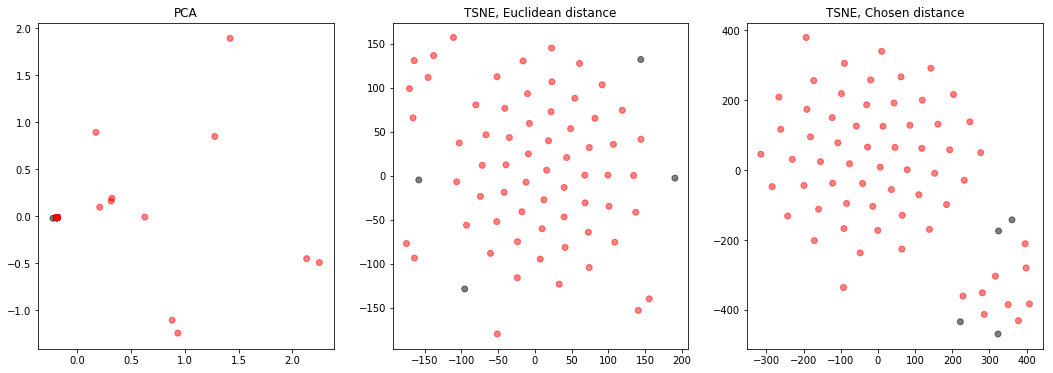

Clustering


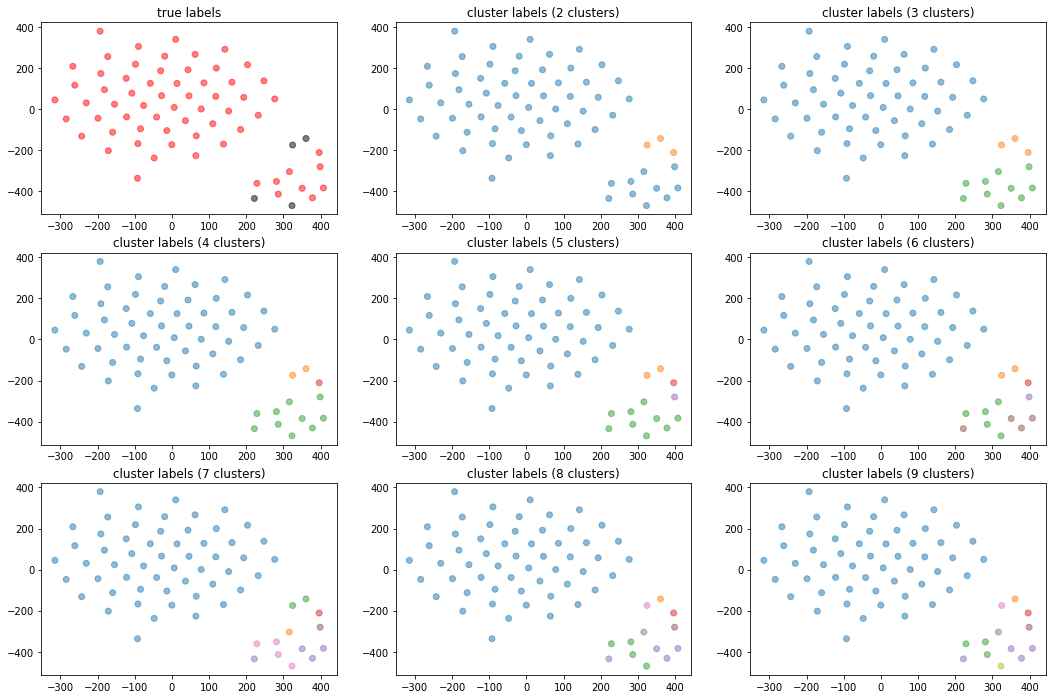

0 cluster


,s_MAIN_ID,s_class,s_nan_spectra,gev_1FGL_Name,gev_CLASS1,tev_fermi_names,tev_classes,marked
10,b'[CHP2004] J095549.8+693934',B0Ve,True,b'1FGL J0956.5+6938 ',b'sbg ',"b'1FGL J0956.5+6938,2FGL J0955.9+6936,3FGL J09...",b'galaxy',0
11,b'[MTK2001b] 8',B0Ve,True,b'1FGL J0956.5+6938 ',b'sbg ',"b'1FGL J0956.5+6938,2FGL J0955.9+6936,3FGL J09...",b'galaxy',0
12,b'[CHP2004] J095637.5+694137',B0Ve,True,b'1FGL J0956.5+6938 ',b'sbg ',"b'1FGL J0956.5+6938,2FGL J0955.9+6936,3FGL J09...",b'galaxy',0
13,b'CXOU J095601.7+694308',B0Ve,True,b'1FGL J0956.5+6938 ',b'sbg ',"b'1FGL J0956.5+6938,2FGL J0955.9+6936,3FGL J09...",b'galaxy',0
14,b'CXOU J095548.9+694010',B0Ve,True,b'1FGL J0956.5+6938 ',b'sbg ',"b'1FGL J0956.5+6938,2FGL J0955.9+6936,3FGL J09...",b'galaxy',0
15,b'CXOU J095527.1+693923',B0Ve,True,b'1FGL J0956.5+6938 ',b'sbg ',"b'1FGL J0956.5+6938,2FGL J0955.9+6936,3FGL J09...",b'galaxy',0
16,b'CXOU J095552.8+694020',B0Ve,True,b'1FGL J0956.5+6938 ',b'sbg ',"b'1FGL J0956.5+6938,2FGL J0955.9+6936,3FGL J09...",b'galaxy',0
17,b'CXOU J095552.4+694024',B0Ve,True,b'1FGL J0956.5+6938 ',b'sbg ',"b'1FGL J0956.5+6938,2FGL J0955.9+6936,3FGL J09...",b'galaxy',0
18,b'CXOU J095550.7+694039',B0Ve,True,b'1FGL J0956.5+6938 ',b'sbg ',"b'1FGL J0956.5+6938,2FGL J0955.9+6936,3FGL J09...",b'galaxy',0
19,b'CXOU J095547.5+694120',B0Ve,True,b'1FGL J0956.5+6938 ',b'sbg ',"b'1FGL J0956.5+6938,2FGL J0955.9+6936,3FGL J09...",b'galaxy',0


1 cluster


,s_MAIN_ID,s_class,s_nan_spectra,gev_1FGL_Name,gev_CLASS1,tev_fermi_names,tev_classes,marked
1,b'LS IV -05 11',B,False,b' ',b'PWN ',b'',b'unid',0
9,b'LS I +61 303',B0Ve,False,b'1FGL J0240.5+6113 ',b'HMB ',b'',b'bin',1
60,b'V* V479 Sct',B0Ve,False,b'1FGL J1826.2-1450 ',b'HMB ',b'',b'bin',1


2 cluster


,s_MAIN_ID,s_class,s_nan_spectra,gev_1FGL_Name,gev_CLASS1,tev_fermi_names,tev_classes,marked
0,b'SSTGC 519103',Be,False,b' ',b' ',b'',b'unid',0
2,b'GCIRS 1W',B,False,b' ',b' ',b'',b'unid',0
3,b'[MCD2010] 18',O,False,b'1FGL J1746.4-2849c',b'pwn ',b'',b'unid',0
4,b'GCIRS 8',O,False,b' ',b' ',b'',b'unid',0
5,b'[MCD2010] 13',O,False,b'1FGL J1746.4-2849c',b'pwn ',b'',b'unid',0
6,b'[MCD2010] 13',O,False,b'1FGL J1746.4-2849c',b'pwn ',b'',b'unid',0
7,b'[MT91] 213',B0Ve,False,b'1FGL J2032.2+4127 ',b'PSR ',b'',b'unid',1
8,b'Schulte 21',B0Ve,False,b'1FGL J2032.2+4127 ',b'PSR ',b'',b'unid',0
38,b'2FGL J1019.0-5856',B0Ve,True,b'1FGL J1018.6-5856 ',b'HMB ',b'1FGL J1018.6-5856',b'bin',1
56,b'[KRL2007b] 332',B0Ve,False,b' ',b'PWN ',b'',b'unid',0


centroids:


,gev_nuFnu10000_100000,gev_nuFnu1000_3000,gev_nuFnu100_300,gev_nuFnu3000_10000,gev_nuFnu300_1000,gev_nuFnu30_100,s_FLUX_U,s_FLUX_B,s_FLUX_V,s_FLUX_R,...,s_FLUX_u,s_FLUX_g,s_FLUX_r,s_FLUX_i,s_FLUX_z,tev_0.3TeV,tev_1TeV,tev_3TeV,tev_10TeV,tev_30TeV
0,0.035190,0.029704,0.035190,0.029730,0.024588,0.0,5.213492e-11,5.081964e-12,0.000001,0.000000e+00,...,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.038109,0.012946,0.001108,0.033685,0.004851,0.0,1.958682e-08,3.333333e-01,0.333333,1.042954e-08,...,0.0,0.333333,0.333333,0.333333,0.0,0.086821,0.227423,0.210271,0.293162,0.293162
2,0.056423,0.287223,0.020726,0.319480,0.258867,0.0,1.000000e-01,5.873577e-03,0.006744,1.000000e-01,...,0.0,0.000000,0.000000,0.000000,0.0,0.274446,0.287238,0.290416,0.290878,0.182563


In [27]:
x = spectra_without_line_normalization[spectrum_columns].values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
spectra_without_line_normalization[spectrum_columns] = pd.DataFrame(x_scaled)

# earth mover's distance
metric_function = st.wasserstein_distance
spectra_distances = pairwise_distances(spectra_without_line_normalization[spectrum_columns], metric=metric_function)
# spectra_distances = get_distance_metric(metric_function).pairwise(spectra[spectrum_columns])
#pd.DataFrame(spectra_distances).to_csv(path_to_gamma_bins +"markeddata/gevtev_spectra_EM_distances.txt", index=False)
build_images(spectra_distances, TSNE_learning_rate=400, TSNE_n_iter=1000, TSNE_learning_rate2=900)
print_clusters_structure(spectra_distances, 3)

All catalogs for normalized columns and non normalized spectra:

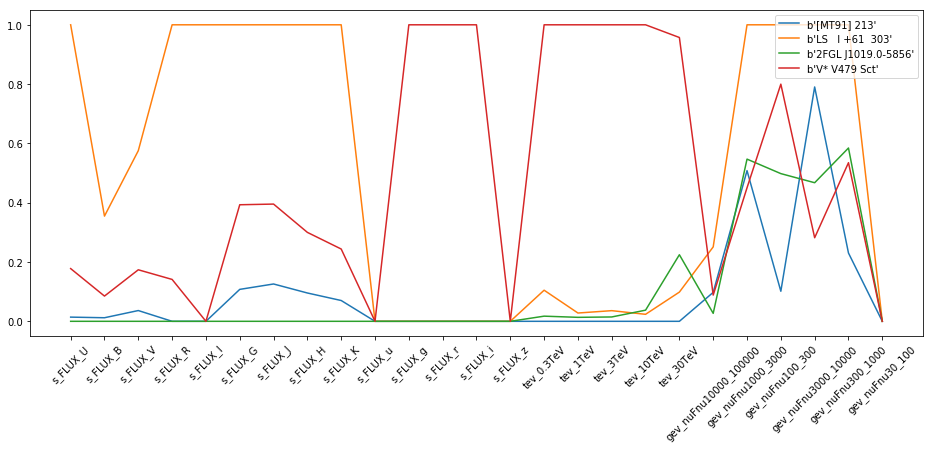

In [28]:
show_marked_spectra2(spectrum_columns, spectra_without_line_normalization)

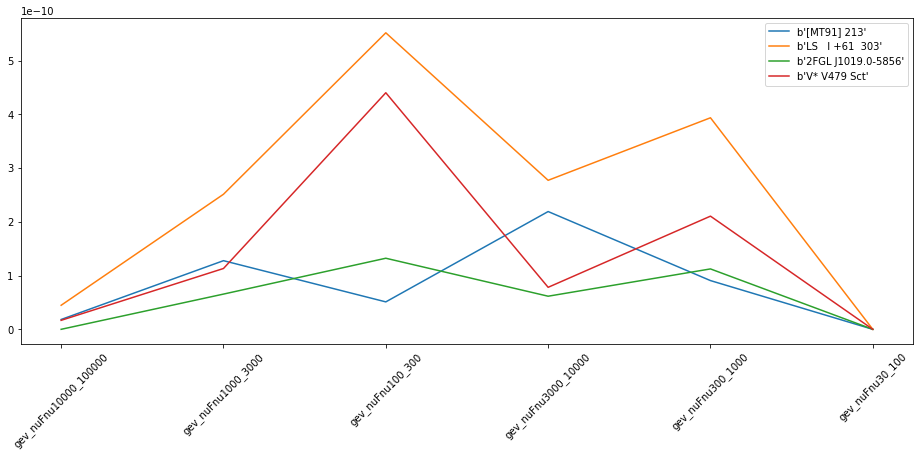

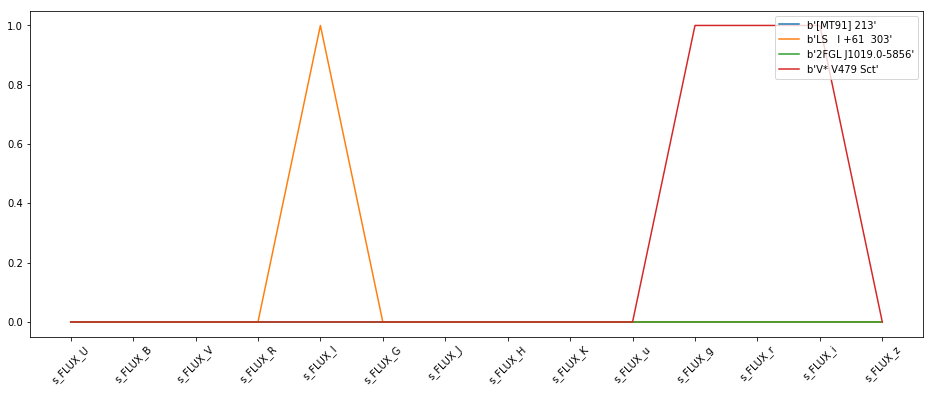

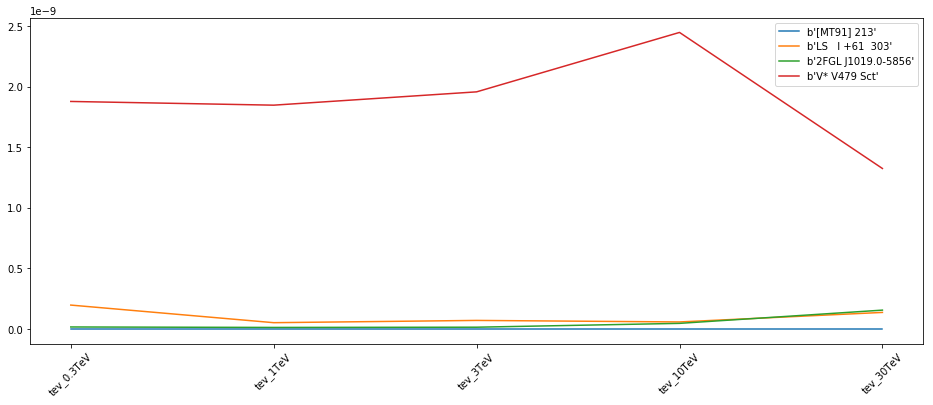

In [29]:
show_marked_spectra2(spectrum_columns[0:6], spectra, 0)
show_marked_spectra2(spectrum_columns[6:20], spectra, 0)
show_marked_spectra2(spectrum_columns[20:], spectra, 0)

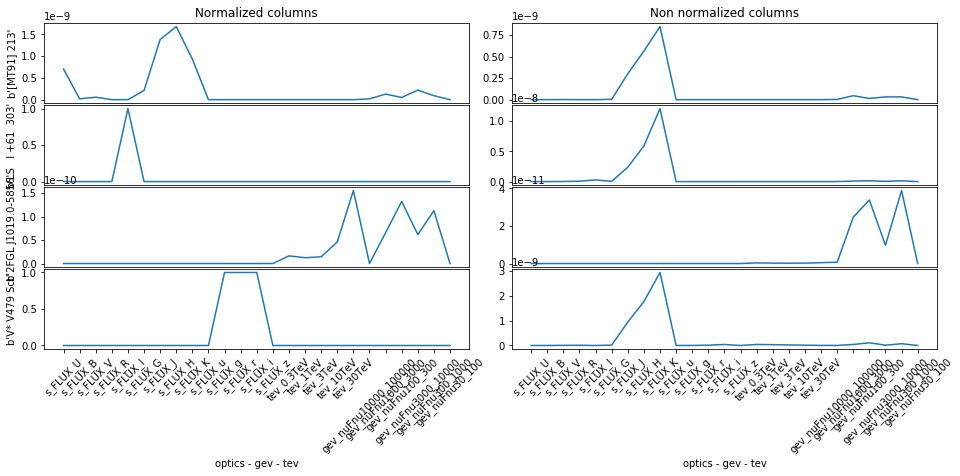

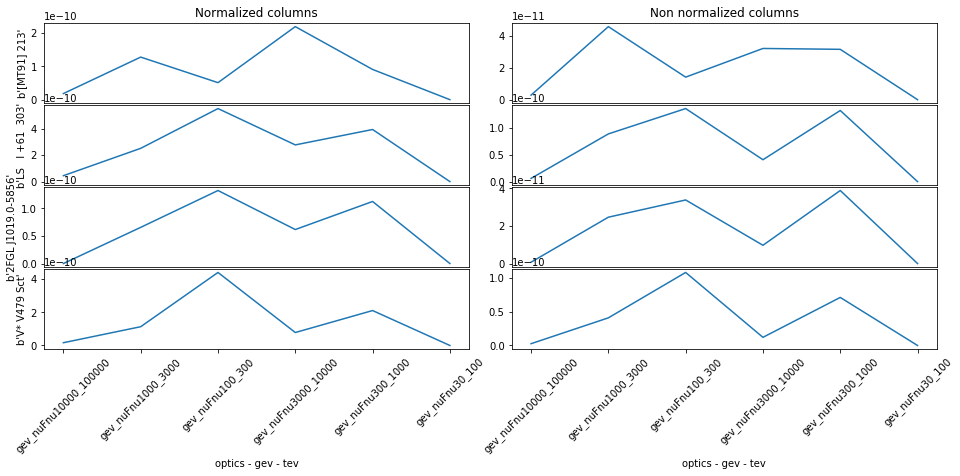

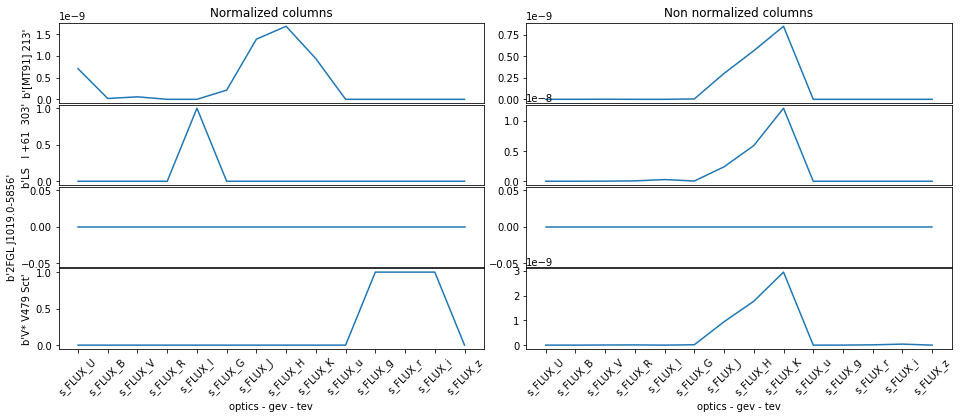

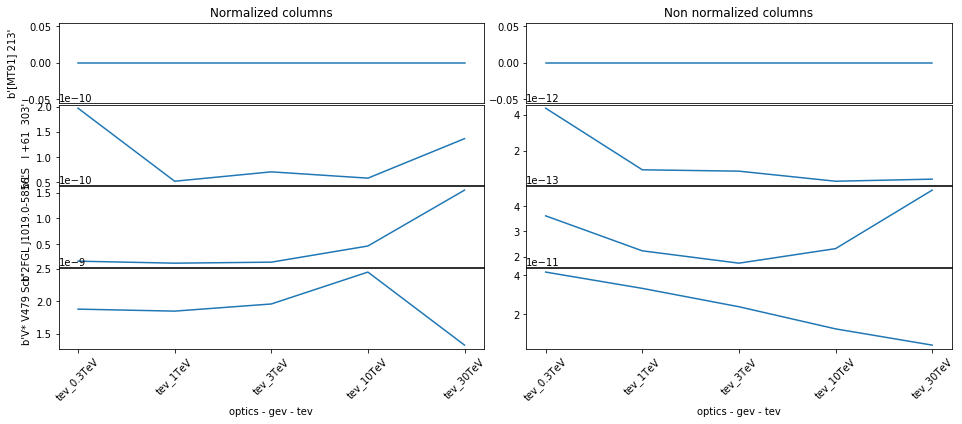

In [30]:
show_marked_spectra(spectrum_columns)
show_marked_spectra(spectrum_columns[0:6], spectra, 0)
show_marked_spectra(spectrum_columns[6:20], spectra, 0)
show_marked_spectra(spectrum_columns[20:], spectra, 0)